In [1]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# function to set random colors to plot bars
def randomColorsToBars(color_start, increment_value, plot):
    cmap = plt.get_cmap('Paired')
    for patch in plot.patches:
        color = cmap(color_start)
        patch.set_color(color)
        color_start += increment_value

# init legends colors
cmap = plt.get_cmap('jet')
blue = cmap(0.25)
orange = cmap(0.8)
handles = [Rectangle((0,0), 1, 1, color=c, ec="k") for c in [blue, orange]]

In [3]:
df = pd.read_csv("D:\\BIG DATA\\pro.csv")
categorical = ['gender','hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'smoking_status']
numerical = ['avg_glucose_level', 'bmi','age']

df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,10.0,0,0,No,children,Urban,58.64,20.4,never smoked,0
43396,5450,Female,56.0,0,0,Yes,Govt_job,Urban,213.61,55.4,formerly smoked,0
43397,28375,Female,82.0,1,0,Yes,Private,Urban,91.94,28.9,formerly smoked,0
43398,27973,Male,40.0,0,0,Yes,Private,Urban,99.16,33.2,never smoked,0


### **Dataset generic info**

In [4]:
df.describe(include="all")

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,43400.000000,43400,43400.000000,43400.000000,43400.000000,43400,43400,43400,43400.000000,41938.000000,43400,43400.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,25665,NaN,NaN,NaN,27938,24834,21756,NaN,NaN,16053,NaN
mean,36326.142350,NaN,42.217894,0.093571,0.047512,NaN,NaN,NaN,104.482750,28.605038,NaN,0.018041
std,21072.134879,NaN,22.519649,0.291235,0.212733,NaN,NaN,NaN,43.111751,7.770020,NaN,0.133103
min,1.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.000000,10.100000,NaN,0.000000
25%,18038.500000,NaN,24.000000,0.000000,0.000000,NaN,NaN,NaN,77.540000,23.200000,NaN,0.000000
50%,36351.500000,NaN,44.000000,0.000000,0.000000,NaN,NaN,NaN,91.580000,27.700000,NaN,0.000000
75%,54514.250000,NaN,60.000000,0.000000,0.000000,NaN,NaN,NaN,112.070000,32.900000,NaN,0.000000


## **Check for null values**

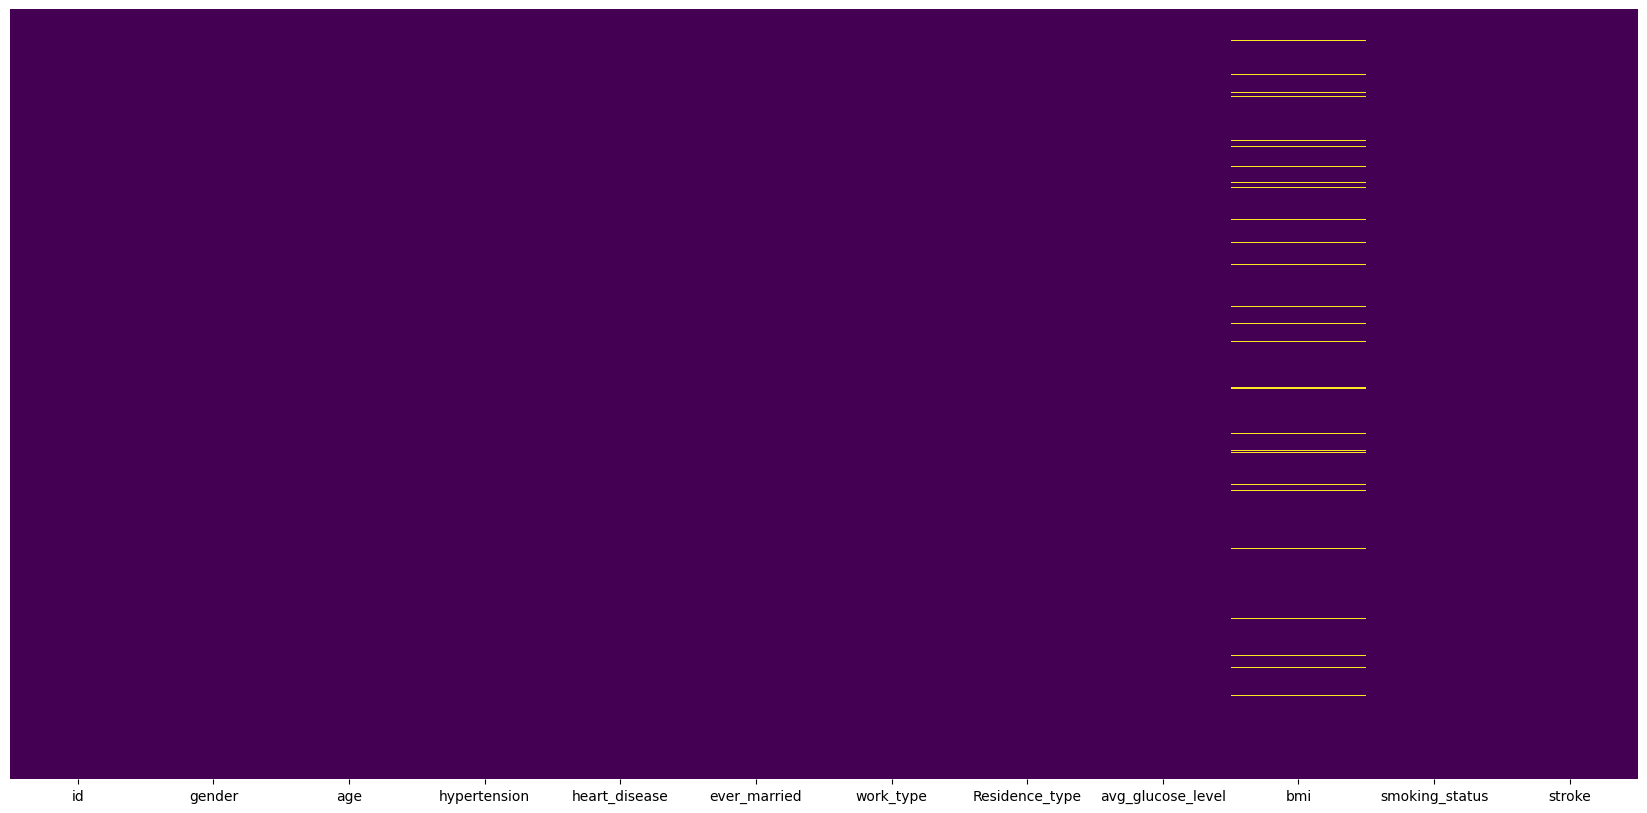

In [5]:
plt.figure(figsize = (21,10))

# this heatmap show us where are the null values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [6]:
print('Bmi null values:', df['bmi'].isna().sum(), sep=' ')

Bmi null values: 1462


## **Replace null values**

* Divide the ages in four groups, get the bmi mean of each group and fill null
values of each group with the corresponding bmi mean

In [7]:
max_age = df["age"].max()
group_size = round(max_age/4)
group_size

20

* First group age [0:20] get bmi mean

In [8]:
# the rows with age between 0 and 20 will be set to true
age1 = df.groupby(df['age'].between(0, group_size, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean1 = round(age1[age1["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean1

21.9

* Second group age [21:40] get bmi mean

In [9]:
# the rows with age between 21 and 40 will be set to true
age2 = df.groupby(df['age'].between(group_size+1, group_size*2, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean2 = round(age2[age2["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean2

29.7

* Third group age [41:60] get bmi mean

In [10]:
# the rows with age between 41 and 60 will be set to true
age3 = df.groupby(df['age'].between(group_size*2+1, group_size*3, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean3 = round(age3[age3["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean3

31.3

* Fourth group age [61:82] get bmi mean

In [11]:
# the rows with age between 61 and 82 will be set to true
age4 = df.groupby(df['age'].between(group_size*3+1, max_age, inclusive=True))['bmi'].mean().reset_index(name='bmi_mean')
bmi_mean4 = round(age3[age4["age"]==True]["bmi_mean"].iloc[0], 1) # get bmi mean of true rows
bmi_mean4

31.3

Create new rows

In [12]:
# get rows with age between specific range where bmi is null and fill it with bmi mean corresponding to the age range
new_rows1 = df[((df["age"]>=0) & (df["age"]<=group_size) & (df["bmi"].isna()))].fillna(bmi_mean1)
new_rows2 = df[((df["age"]>=group_size+1) & (df["age"]<=group_size*2) & (df["bmi"].isna()))].fillna(bmi_mean2)
new_rows3 = df[((df["age"]>=group_size*2+1) & (df["age"]<=group_size*3) & (df["bmi"].isna()))].fillna(bmi_mean3)
new_rows4 = df[((df["age"]>=group_size*3+1) & (df["age"]<=max_age) & (df["bmi"].isna()))].fillna(bmi_mean4)

new_rows = new_rows1.append(new_rows2.append(new_rows3.append(new_rows4)))
new_rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
503,33723,Female,9.0,0,0,No,children,Urban,95.81,21.9,Unknown,0
635,2549,Female,17.0,0,0,No,Private,Rural,83.23,21.9,never smoked,0
883,809,Male,13.0,0,0,No,children,Urban,71.73,21.9,Unknown,0
963,542,Female,3.0,0,0,No,children,Urban,79.63,21.9,Unknown,0
1047,33187,Female,6.0,0,0,No,children,Urban,201.25,21.9,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43213,5831,Female,78.0,0,0,Yes,Self-employed,Rural,88.17,31.3,formerly smoked,0
43317,2558,Female,62.0,0,1,Yes,Govt_job,Urban,72.29,31.3,never smoked,0
43339,10463,Female,76.0,0,0,No,Private,Rural,100.55,31.3,never smoked,1
43371,18119,Female,78.0,0,0,Yes,Private,Urban,182.45,31.3,formerly smoked,0


Update with new rows removing null values

In [13]:
# update old rows with new rows by index
for index in new_rows.index:
    df.iloc[index] = new_rows.loc[index]

print('Bmi null values:', df['bmi'].isna().sum(), sep=' ')

Bmi null values: 0


### **Gender and stroke**

> **Risultato**: i maschi sono più predisposti ad avere un ictus

Dal momento che gli 'Other' sono irrilevanti, eliminiamo le righe che contengono il genere 'Other'

In [14]:
df.groupby('gender')["gender"].count()

gender
Female    25665
Male      17724
Other        11
Name: gender, dtype: int64

In [15]:
df = df.drop(df[df['gender'] == 'Other'].index)
df.groupby('gender')["gender"].count()

gender
Female    25665
Male      17724
Name: gender, dtype: int64

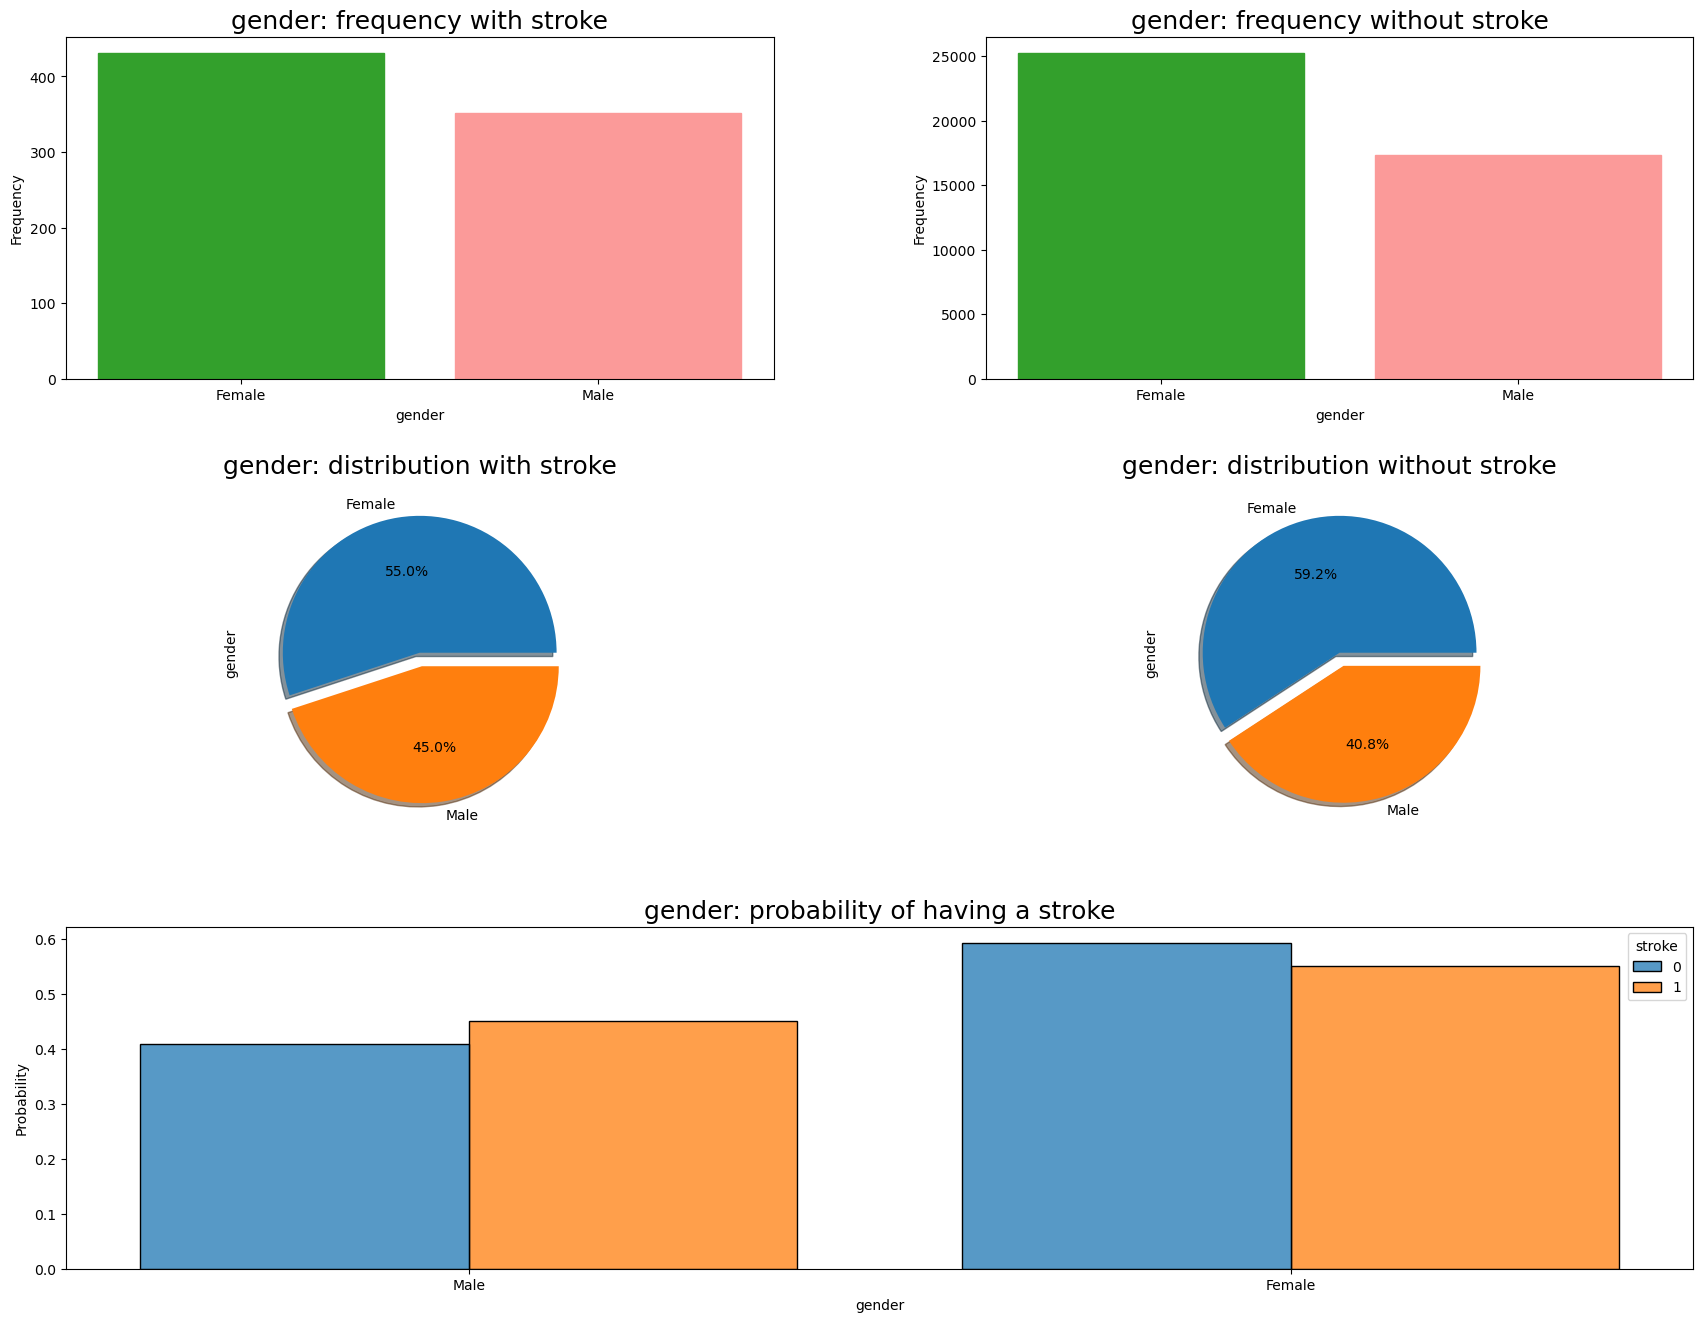

In [16]:
gendersWithStroke = df[df["stroke"]==1].groupby("gender")["gender"].count().reset_index(name='counts')
gendersWithoutStroke = df[df["stroke"]==0].groupby("gender")["gender"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3)  # grid with 3 rows and 2 columns

# plot gender frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(gendersWithStroke["gender"].values, gendersWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("gender")
plt.title("gender: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot gender frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(gendersWithoutStroke["gender"].values, gendersWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("gender")
plt.title("gender: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot gender distribution with stroke
plt.subplot(grid[1, 0])
plt.title("gender: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('gender')['gender'].count().plot(kind='pie', y='gender', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot gender distribution without stroke
plt.subplot(grid[1, 1])
plt.title("gender: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('gender')['gender'].count().plot(kind='pie', y='gender', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot gender probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="gender", hue="stroke", stat="probability", common_norm=False, multiple="dodge", shrink=0.8)
plt.title('gender: probability of having a stroke', size=18)

plt.show()

### **Hypertension and stroke**

> **Risultato**: chi è affetto da ipertensione è più predisposto ad avere un ictus



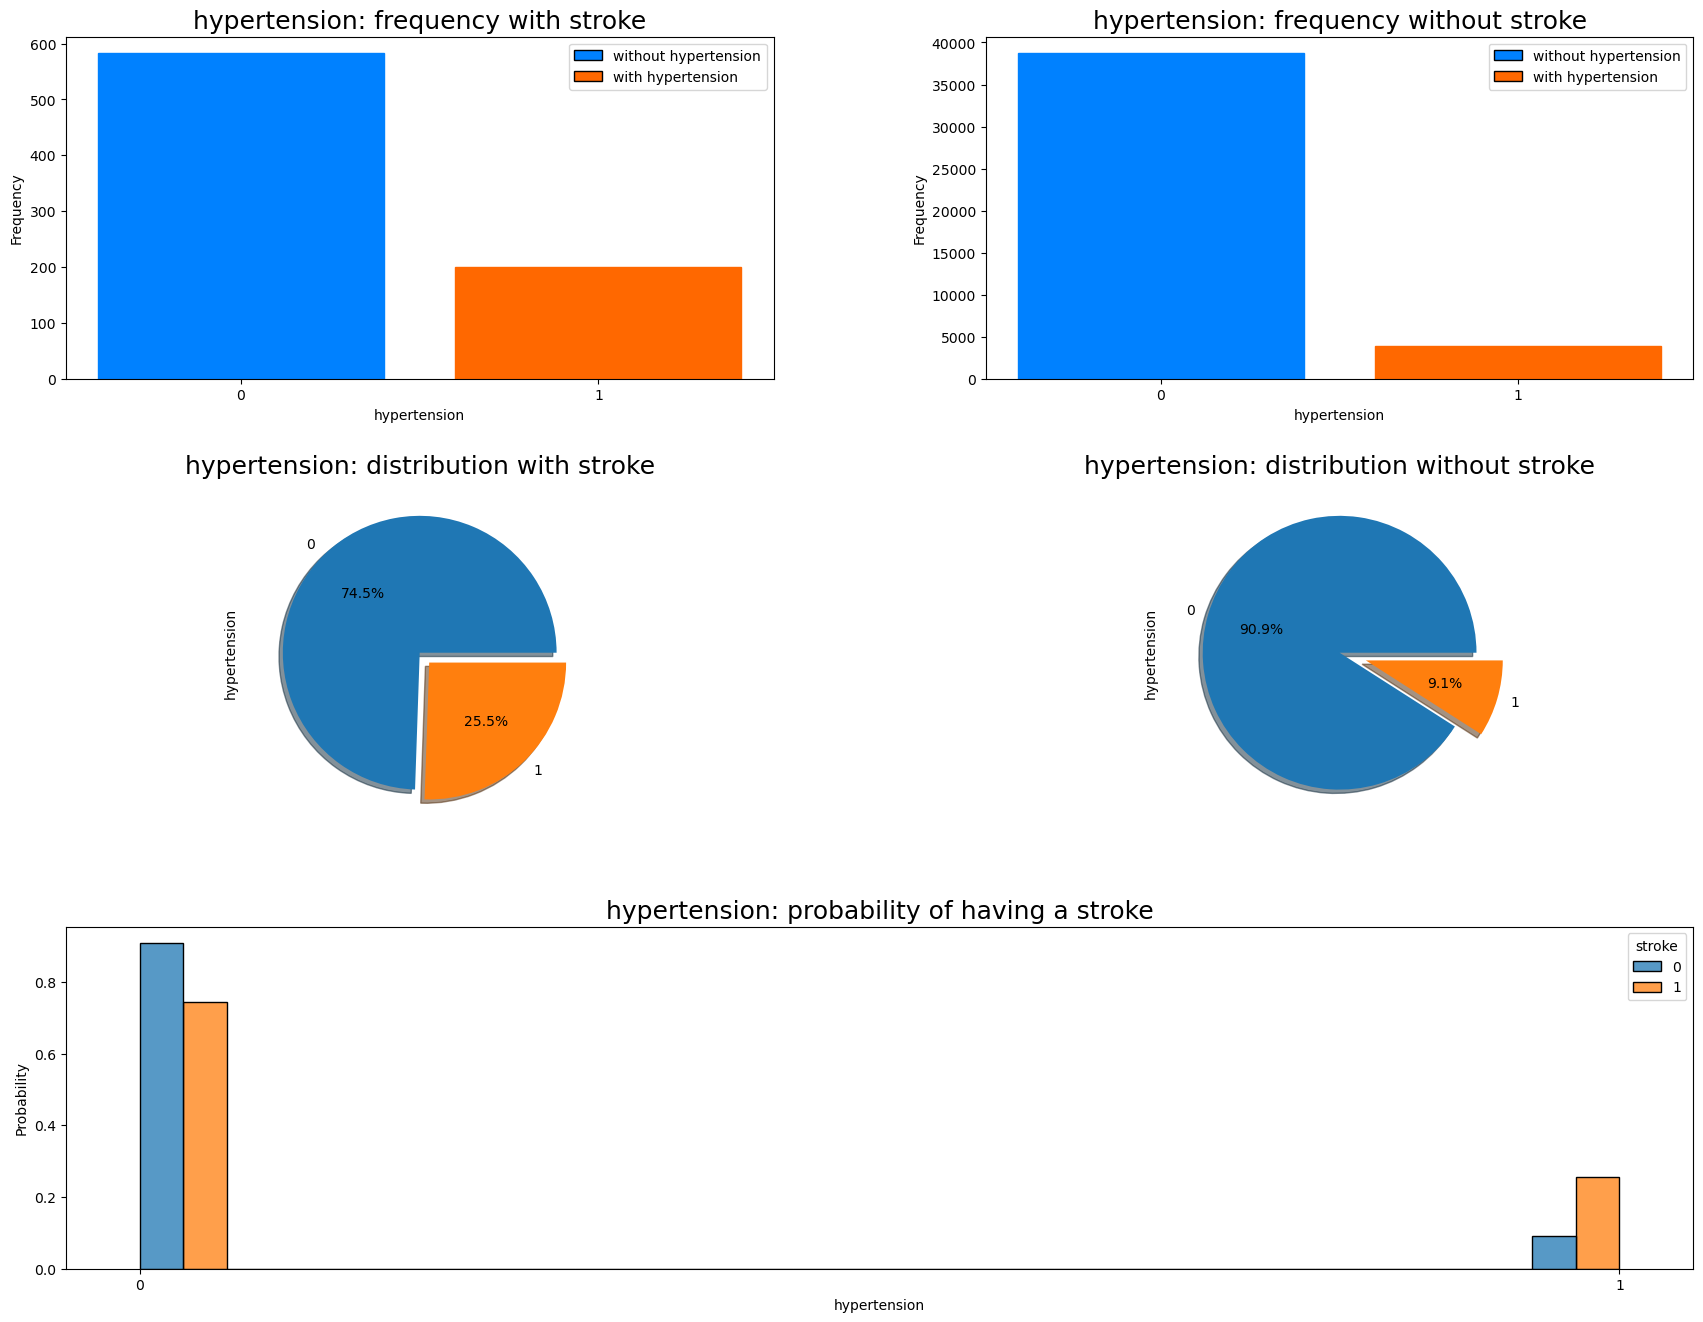

In [17]:
hypertensionsWithStroke = df[df["stroke"]==1].groupby("hypertension")["hypertension"].count().reset_index(name='counts')
hypertensionsWithoutStroke = df[df["stroke"]==0].groupby("hypertension")["hypertension"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot hypertension frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(hypertensionsWithStroke["hypertension"].values, hypertensionsWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("hypertension")
plt.xticks(np.arange(0, 2, 1))
plt.title("hypertension: frequency with stroke", size=18)
labels= ["without hypertension","with hypertension"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot hypertension frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(hypertensionsWithoutStroke["hypertension"].values, hypertensionsWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("hypertension")
plt.xticks(np.arange(0, 2, 1))
plt.title("hypertension: frequency without stroke", size=18)
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot hypertension distribution with stroke
plt.subplot(grid[1, 0])
plt.title("hypertension: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('hypertension')['hypertension'].count().plot(kind='pie', y='hypertension', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot hypertension distribution without stroke
plt.subplot(grid[1, 1])
plt.title("hypertension: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('hypertension')['hypertension'].count().plot(kind='pie', y='hypertension', autopct='%1.1f%%', shadow = True, explode=(0, 0.2))

# plot hypertension probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="hypertension", hue="stroke",  stat="probability", common_norm=False, multiple="dodge")
plt.xticks([0,1])
plt.title('hypertension: probability of having a stroke', size=18)

plt.show()

### **Heart disease and stroke**

> **Risultato**: chi è affetto da cardiopatia è più predisposto ad avere un ictus

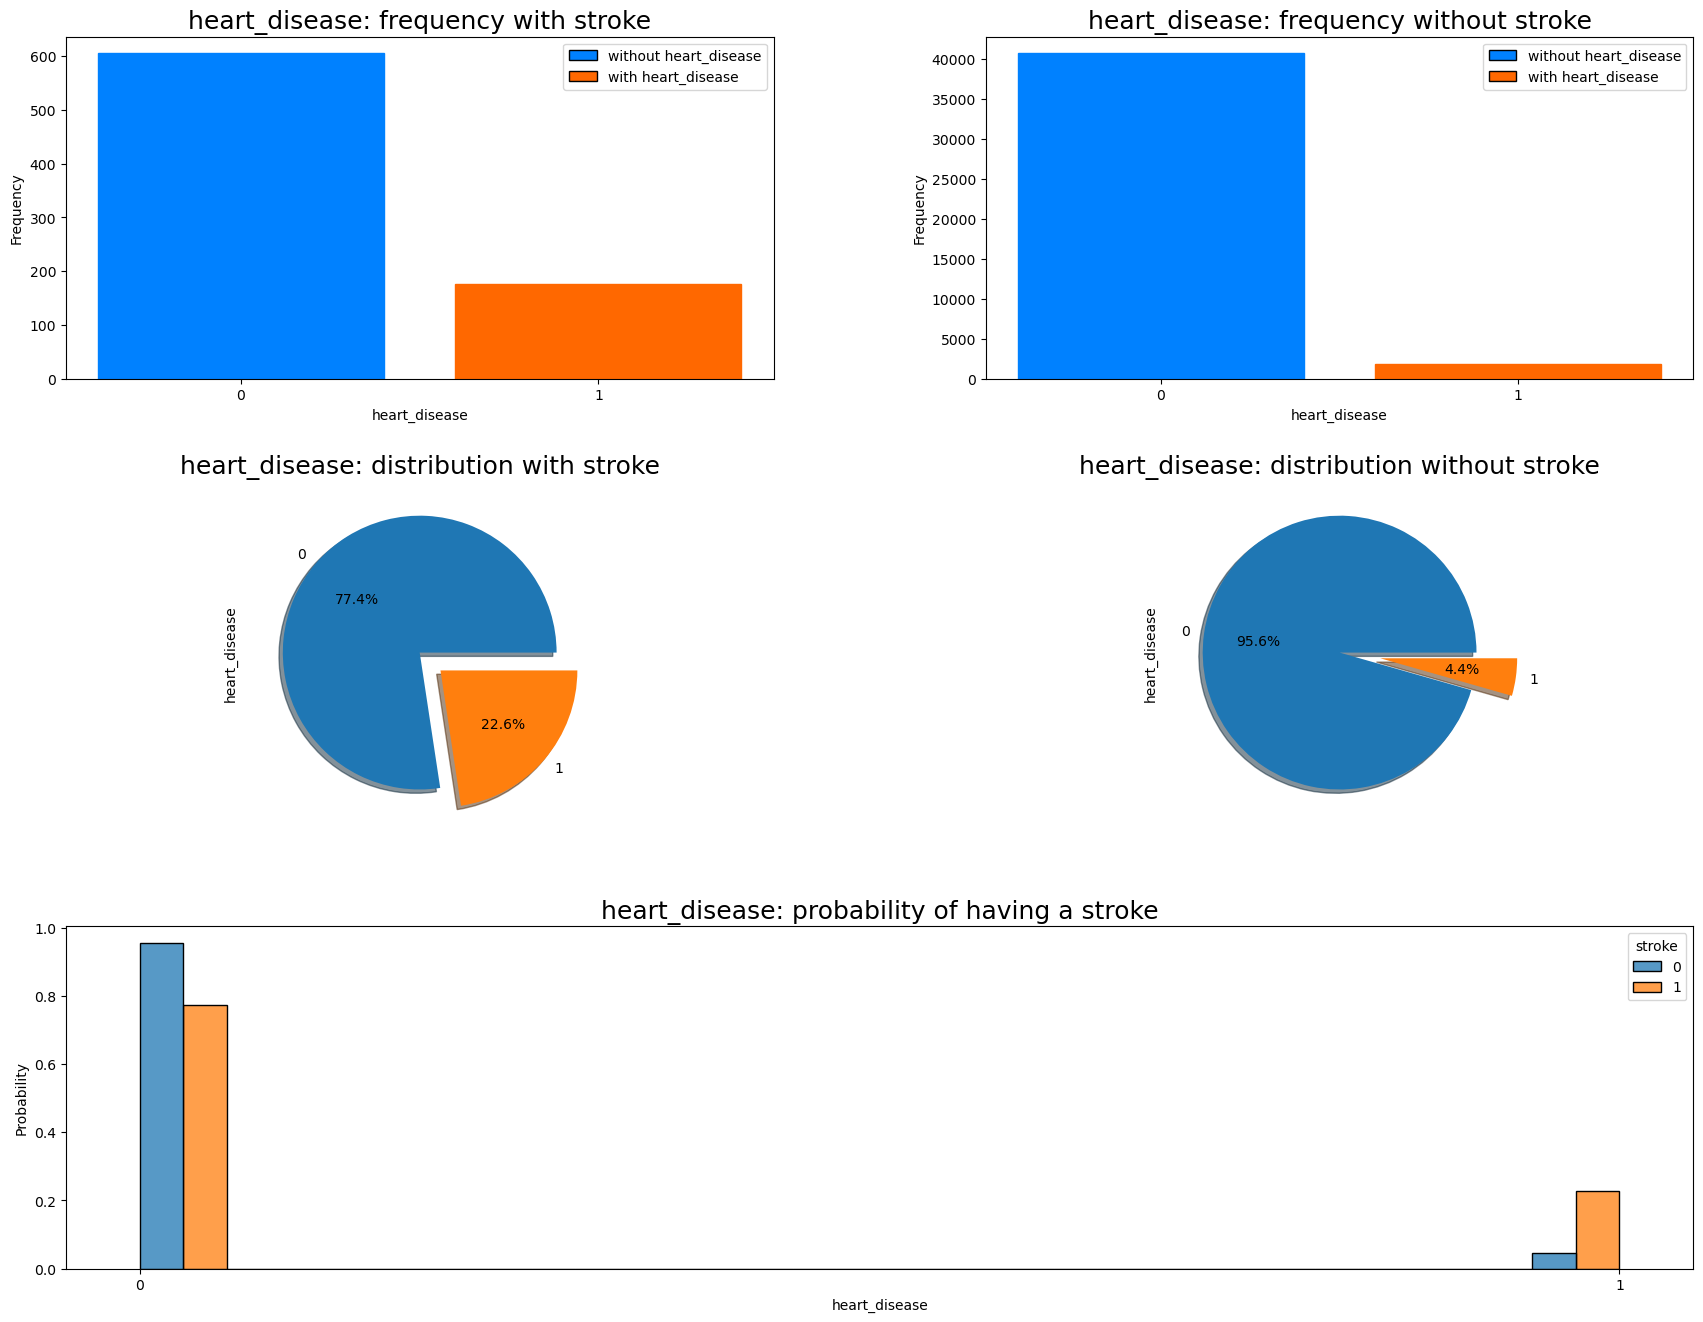

In [18]:
heartDiseaseWithStroke = df[df["stroke"]==1].groupby("heart_disease")["heart_disease"].count().reset_index(name='counts')
heartDiseaseWithoutStroke = df[df["stroke"]==0].groupby("heart_disease")["heart_disease"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot heart_disease frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(heartDiseaseWithStroke["heart_disease"].values, heartDiseaseWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("heart_disease")
plt.xticks(np.arange(0, 2, 1))
plt.title("heart_disease: frequency with stroke", size=18)
labels= ["without heart_disease", "with heart_disease"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot heart_disease frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(heartDiseaseWithoutStroke["heart_disease"].values, heartDiseaseWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("heart_disease")
plt.xticks(np.arange(0, 2, 1))
plt.title("heart_disease: frequency without stroke", size=18)
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot heart_disease distribution with stroke
plt.subplot(grid[1, 0])
plt.title("heart_disease: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('heart_disease')['heart_disease'].count().plot(kind='pie', y='heart_disease', autopct='%1.1f%%', shadow = True, explode=(0, 0.2))

# plot heart_disease distribution without stroke
plt.subplot(grid[1, 1])
plt.title("heart_disease: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('heart_disease')['heart_disease'].count().plot(kind='pie', y='heart_disease', autopct='%1.1f%%', shadow = True, explode=(0, 0.3))

# plot heart_disease probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="heart_disease", hue="stroke",  stat="probability", common_norm=False, multiple="dodge")
plt.xticks([0,1])
plt.title('heart_disease: probability of having a stroke', size=18)

plt.show()

### **Ever married and stroke**


> **Risultato**: chi è sposato, divorziato o vedovo è più predisposto ad avere un ictus

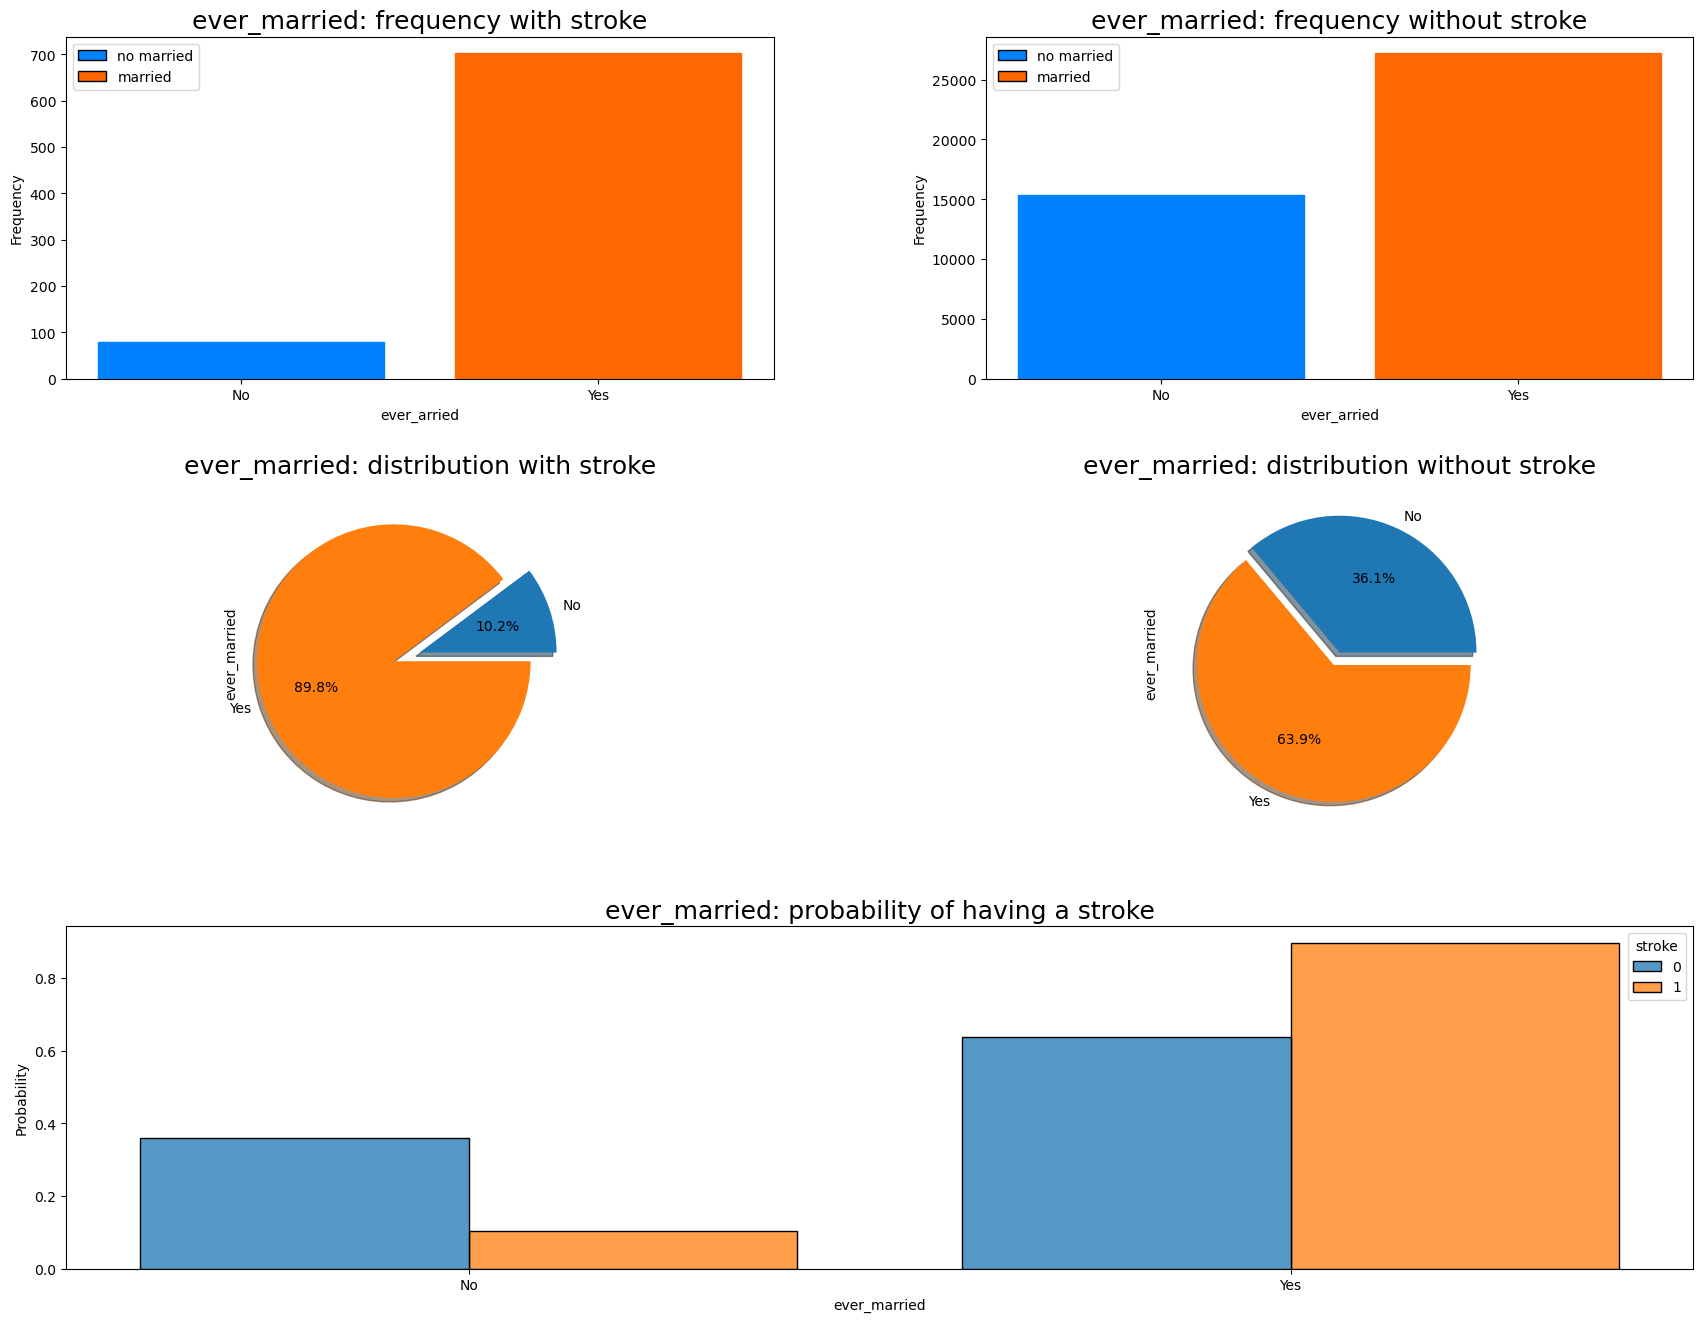

In [19]:
marriedWithStroke = df[df["stroke"]==1].groupby("ever_married")["ever_married"].count().reset_index(name='counts')
marriedWithoutStroke = df[df["stroke"]==0].groupby("ever_married")["ever_married"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot ever_married frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(marriedWithStroke["ever_married"].values, marriedWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("ever_arried")
plt.title("ever_married: frequency with stroke", size=18)
labels= ["no married","married"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot ever_married frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(marriedWithoutStroke["ever_married"].values, marriedWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("ever_arried")
plt.title("ever_married: frequency without stroke", size=18)
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[1].set_color(orange)

# plot ever_married distribution with stroke
plt.subplot(grid[1, 0])
plt.title("ever_married: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('ever_married')['ever_married'].count().plot(kind='pie', y='ever_married', autopct='%1.1f%%', shadow = True, explode=(0, 0.2))

# plot ever_married distribution without stroke
plt.subplot(grid[1, 1])
plt.title("ever_married: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('ever_married')['ever_married'].count().plot(kind='pie', y='ever_married', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot ever_married probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="ever_married", hue="stroke",  stat="probability", common_norm=False, multiple="dodge", shrink=.8)
plt.title('ever_married: probability of having a stroke', size=18)

plt.show()

## **Work type**

> Risultato: chi lavora è più predisposto ad avere un ictus, soprattutto se è un lavoratore autonomo

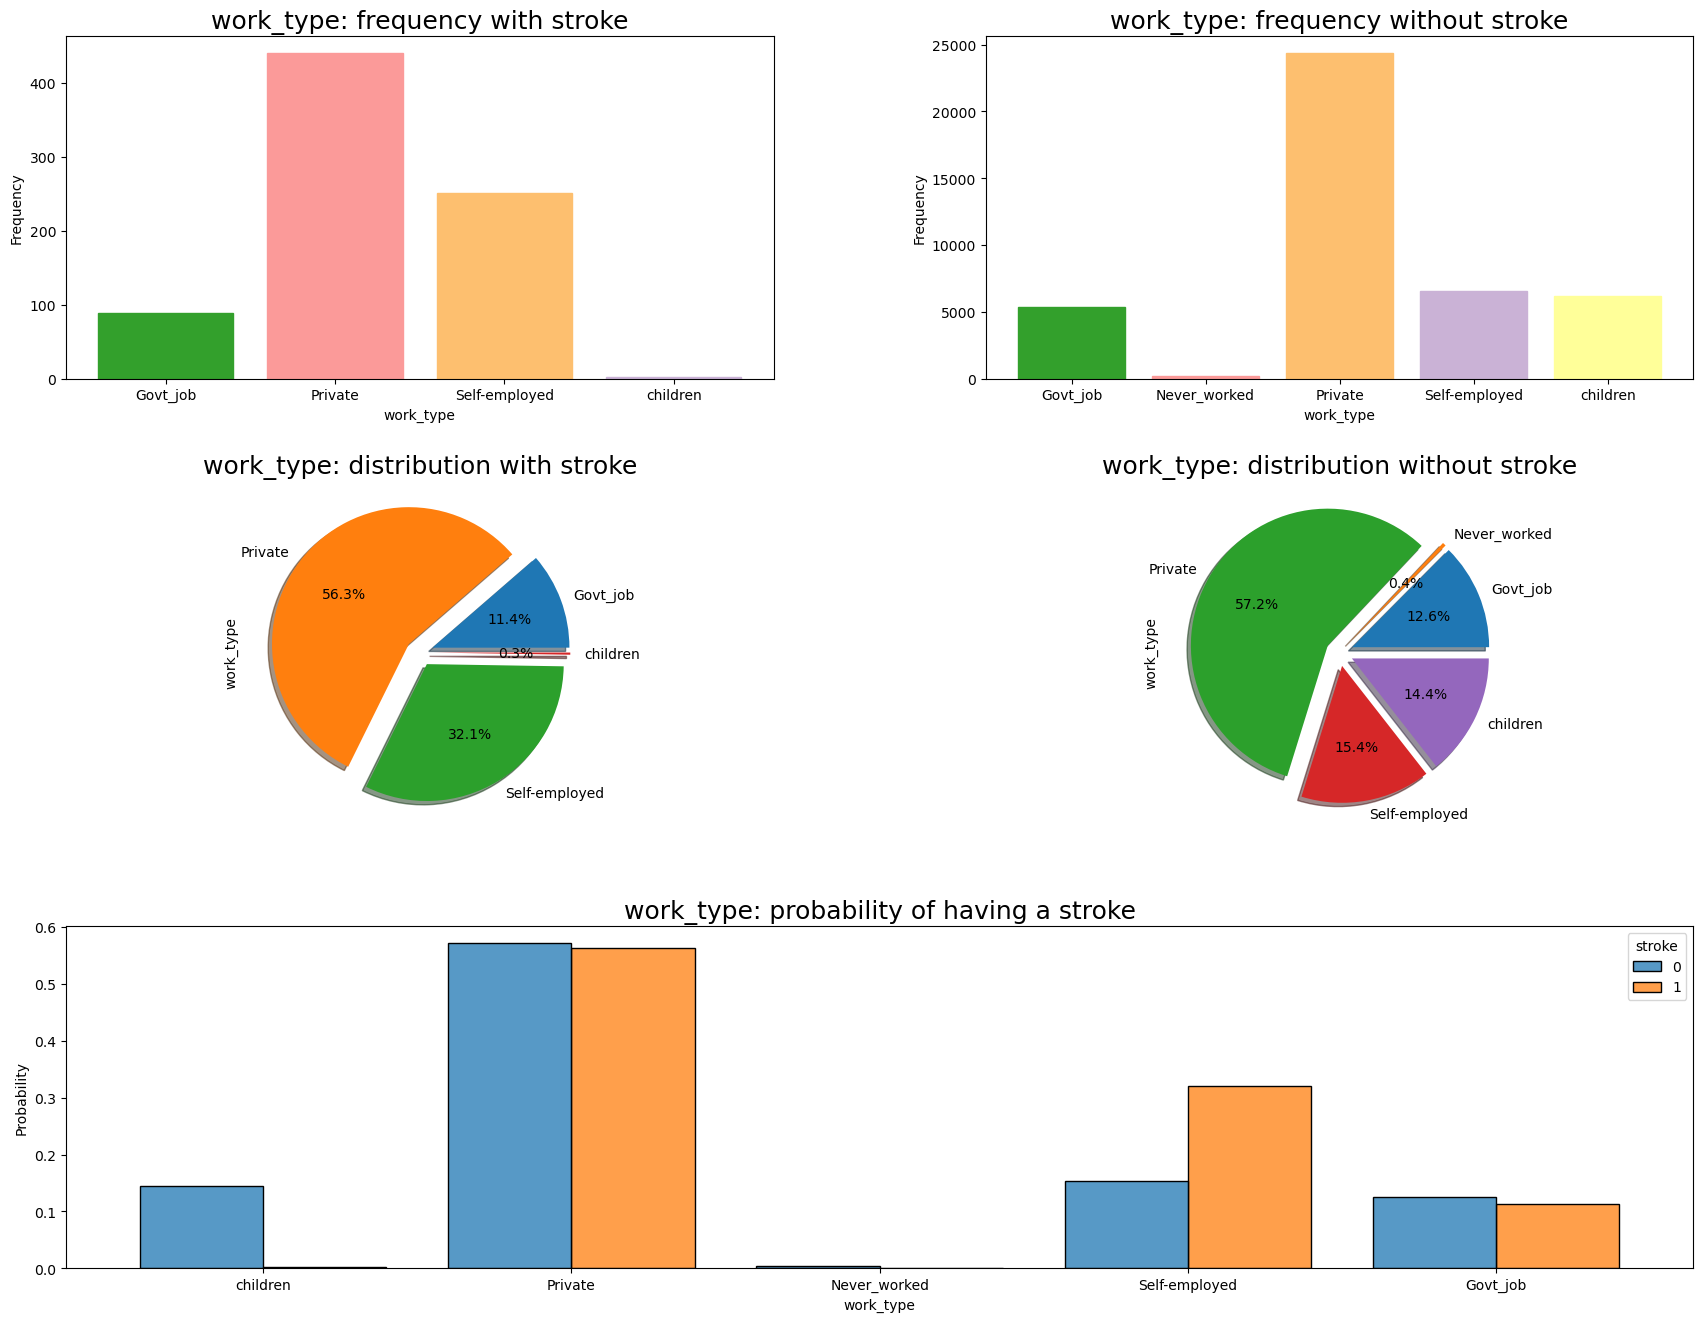

In [20]:
work_typeWithStroke = df[df["stroke"]==1].groupby("work_type")["work_type"].count().reset_index(name='counts')
work_typeWithoutStroke = df[df["stroke"]==0].groupby("work_type")["work_type"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot work_type frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(work_typeWithStroke["work_type"].values, work_typeWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("work_type")
plt.title("work_type: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot work_type frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(work_typeWithoutStroke["work_type"].values, work_typeWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("work_type")
plt.title("work_type: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot work_type distribution with stroke
plt.subplot(grid[1, 0])
plt.title("work_type: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('work_type')['work_type'].count().plot(kind='pie', y='work_type', autopct='%1.1f%%', shadow = True, explode=(0.1, 0.1, 0.1, 0.1))

# plot work_type distribution without stroke
plt.subplot(grid[1, 1])
plt.title("work_type: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('work_type')['work_type'].count().plot(kind='pie', y='work_type', autopct='%1.1f%%', shadow = True, explode=(0.1, 0.1, 0.1, 0.1, 0.1))

# plot work_type probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="work_type", hue="stroke",  stat="probability", common_norm=False, multiple="dodge",  shrink=.8)
plt.title('work_type: probability of having a stroke', size=18)
plt.show()

### **Residence type and stroke**

> **Risultato**: chi lavora in città è più predisposto ad avere un ictus

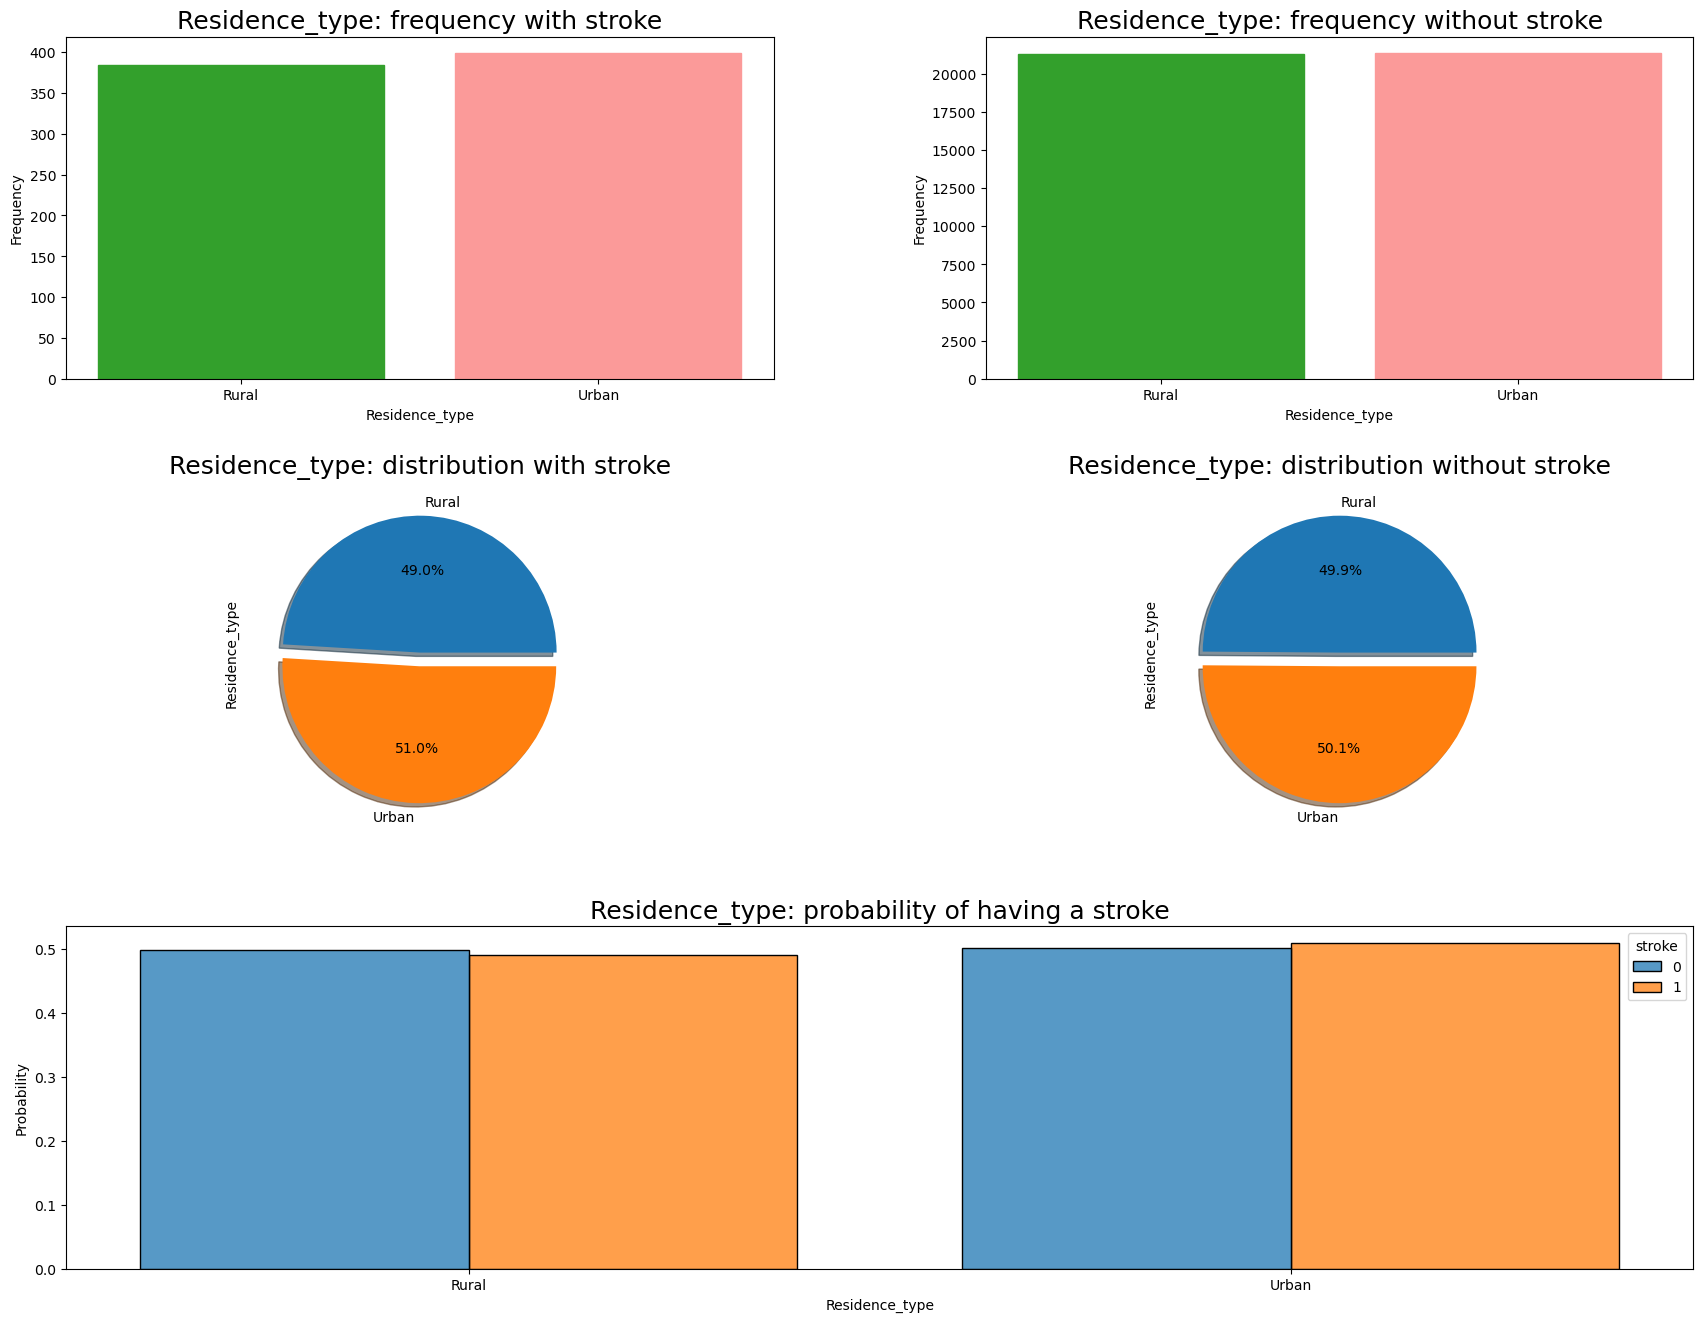

In [21]:
residenceTypeWithStroke = df[df["stroke"]==1].groupby("Residence_type")["Residence_type"].count().reset_index(name='counts')
residenceTypeWithoutStroke = df[df["stroke"]==0].groupby("Residence_type")["Residence_type"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot Residence_type frequency with stroke
plt.subplot(grid[0, 0])
plot = plt.bar(residenceTypeWithStroke["Residence_type"].values, residenceTypeWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("Residence_type")
plt.title("Residence_type: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot Residence_type frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(residenceTypeWithoutStroke["Residence_type"].values, residenceTypeWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("Residence_type")
plt.title("Residence_type: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot Residence_type distribution with stroke
plt.subplot(grid[1, 0])
plt.title("Residence_type: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('Residence_type')['Residence_type'].count().plot(kind='pie', y='Residence_type', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot Residence_type distribution without stroke
plt.subplot(grid[1, 1])
plt.title("Residence_type: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('Residence_type')['Residence_type'].count().plot(kind='pie', y='Residence_type', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))

# plot Residence_type probability of having a stroke
plt.subplot(grid[2, 0:]) # get space of all columns
sns.histplot(df, x="Residence_type", hue="stroke",  stat="probability", common_norm=False, multiple="dodge", shrink=.8)
plt.title('Residence_type: probability of having a stroke', size=18)
plt.show()

## **Smoking status and strokes**

> **Risultato**: chi in passato fumava o attualmente fuma è più predisposto ad avere un ictus. Inoltre chi in passato fumava è più a rischio di chi attualmente fuma.

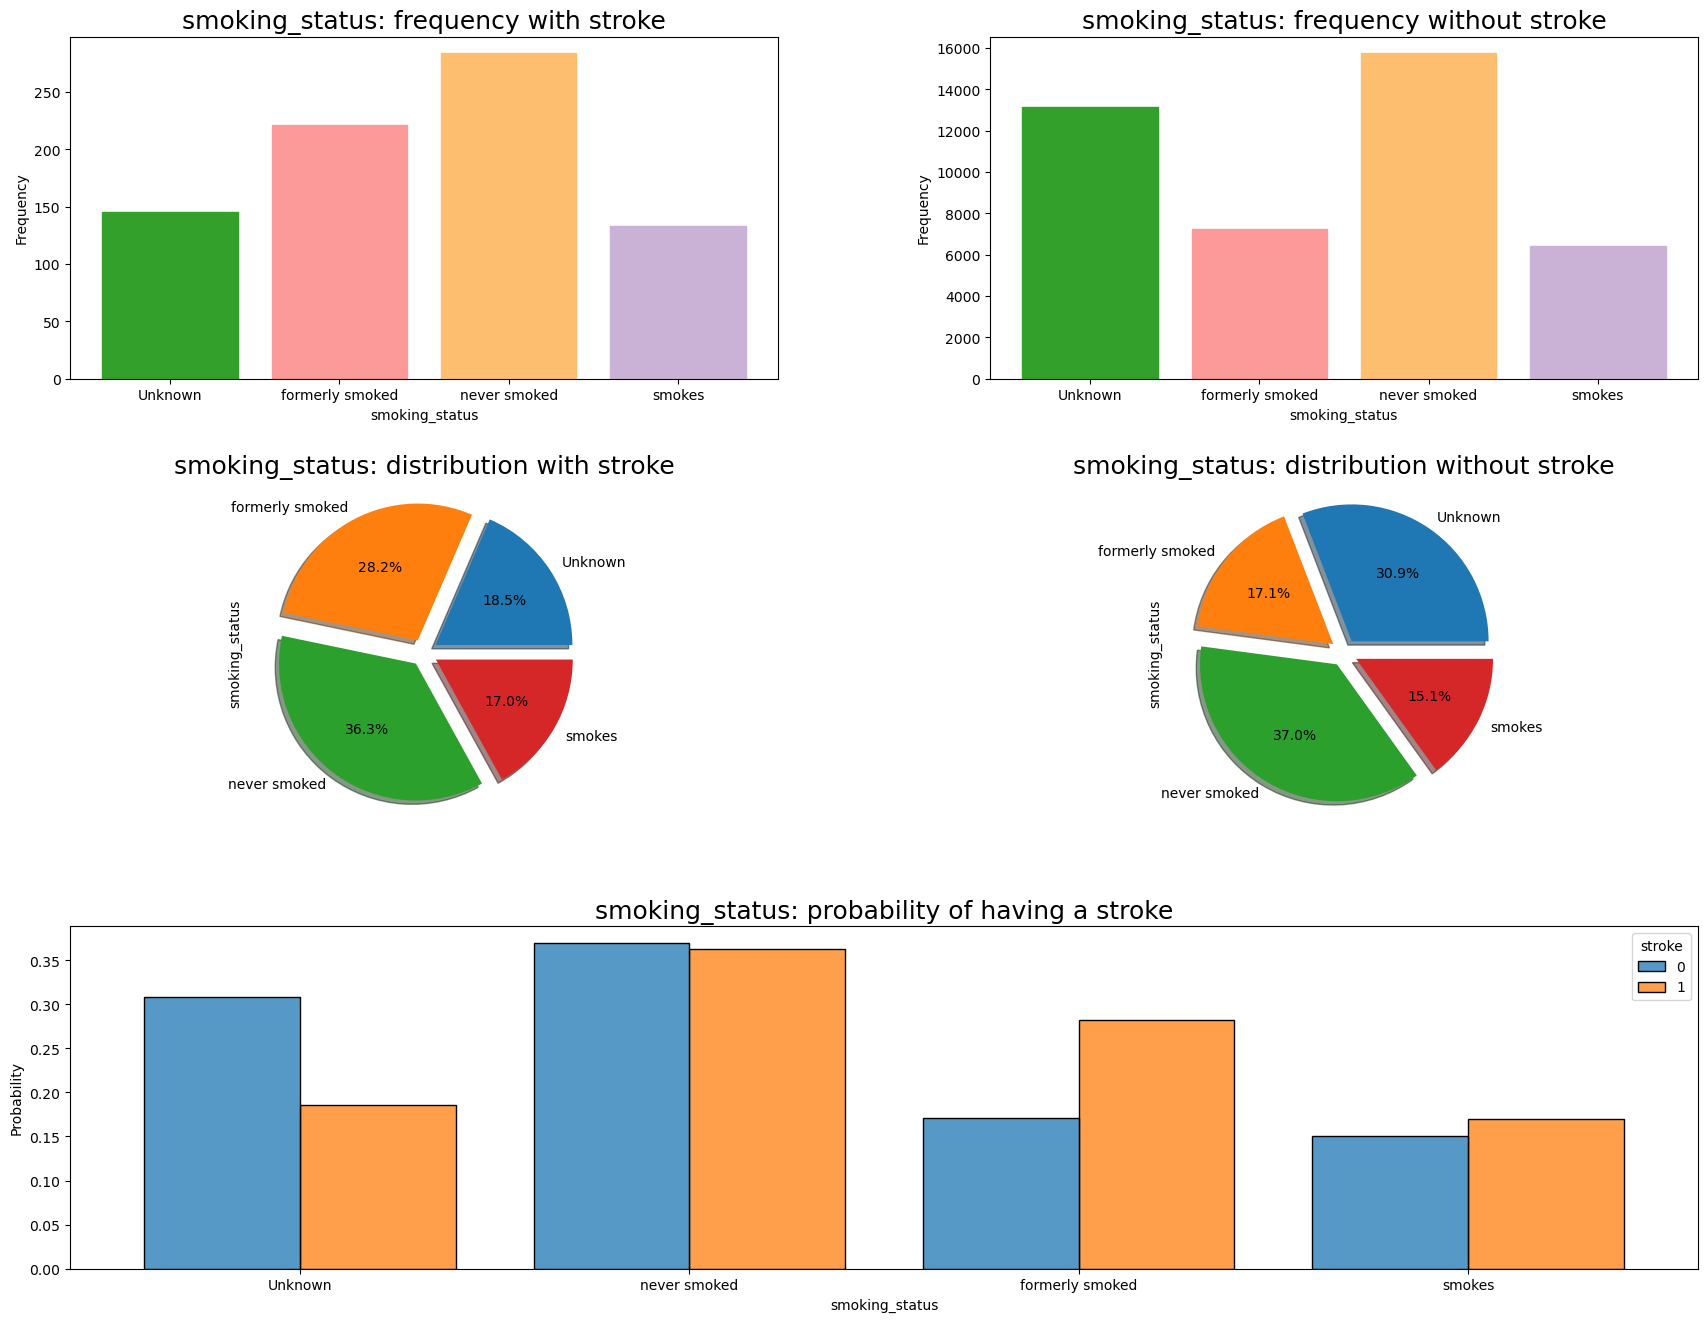

In [22]:
smokeWithStroke = df[df["stroke"]==1].groupby("smoking_status")["smoking_status"].count().reset_index(name='counts')
smokeWithoutStroke = df[df["stroke"]==0].groupby("smoking_status")["smoking_status"].count().reset_index(name='counts')

plt.figure(figsize = (21,16))
grid = plt.GridSpec(3, 2, wspace =0.3, hspace = 0.3) # grid with 3 rows and 2 columns

# plot smoking_status frequency with stroke
plt.subplot(grid[0, 0])
plot= plt.bar(smokeWithStroke["smoking_status"].values, smokeWithStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("smoking_status")
plt.title("smoking_status: frequency with stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot smoking_status frequency without stroke
plt.subplot(grid[0, 1])
plot = plt.bar(smokeWithoutStroke["smoking_status"].values, smokeWithoutStroke["counts"].values)
plt.ylabel("Frequency")
plt.xlabel("smoking_status")
plt.title("smoking_status: frequency without stroke", size=18)
randomColorsToBars(0.25, 0.15, plot);

# plot smoking_status distribution with stroke
plt.subplot(grid[1, 0])
plt.title("smoking_status: distribution with stroke", size=18)
df[df["stroke"]==1].groupby('smoking_status')['smoking_status'].count().plot(kind='pie', y='smoking_status', autopct='%1.1f%%', shadow = True,explode=(0.1, 0.1, 0.1, 0.1))

# plot smoking_status distribution without stroke
plt.subplot(grid[1, 1])
plt.title("smoking_status: distribution without stroke", size=18)
df[df["stroke"]==0].groupby('smoking_status')['smoking_status'].count().plot(kind='pie', y='smoking_status', autopct='%1.1f%%', shadow = True,explode=(0.1, 0.1, 0.1, 0.1))

# plot smoking_status probability of having a stroke
plt.subplot(grid[2,0:]) # get space of all columns
sns.histplot(df, x="smoking_status", hue="stroke",  stat="probability", common_norm=False, multiple="dodge", shrink=.8)
plt.title("smoking_status: probability of having a stroke", size=18)
plt.show()

### **Age and stroke**

> **Risultato**: chi è più anziano è più predisposto ad avere un ictus

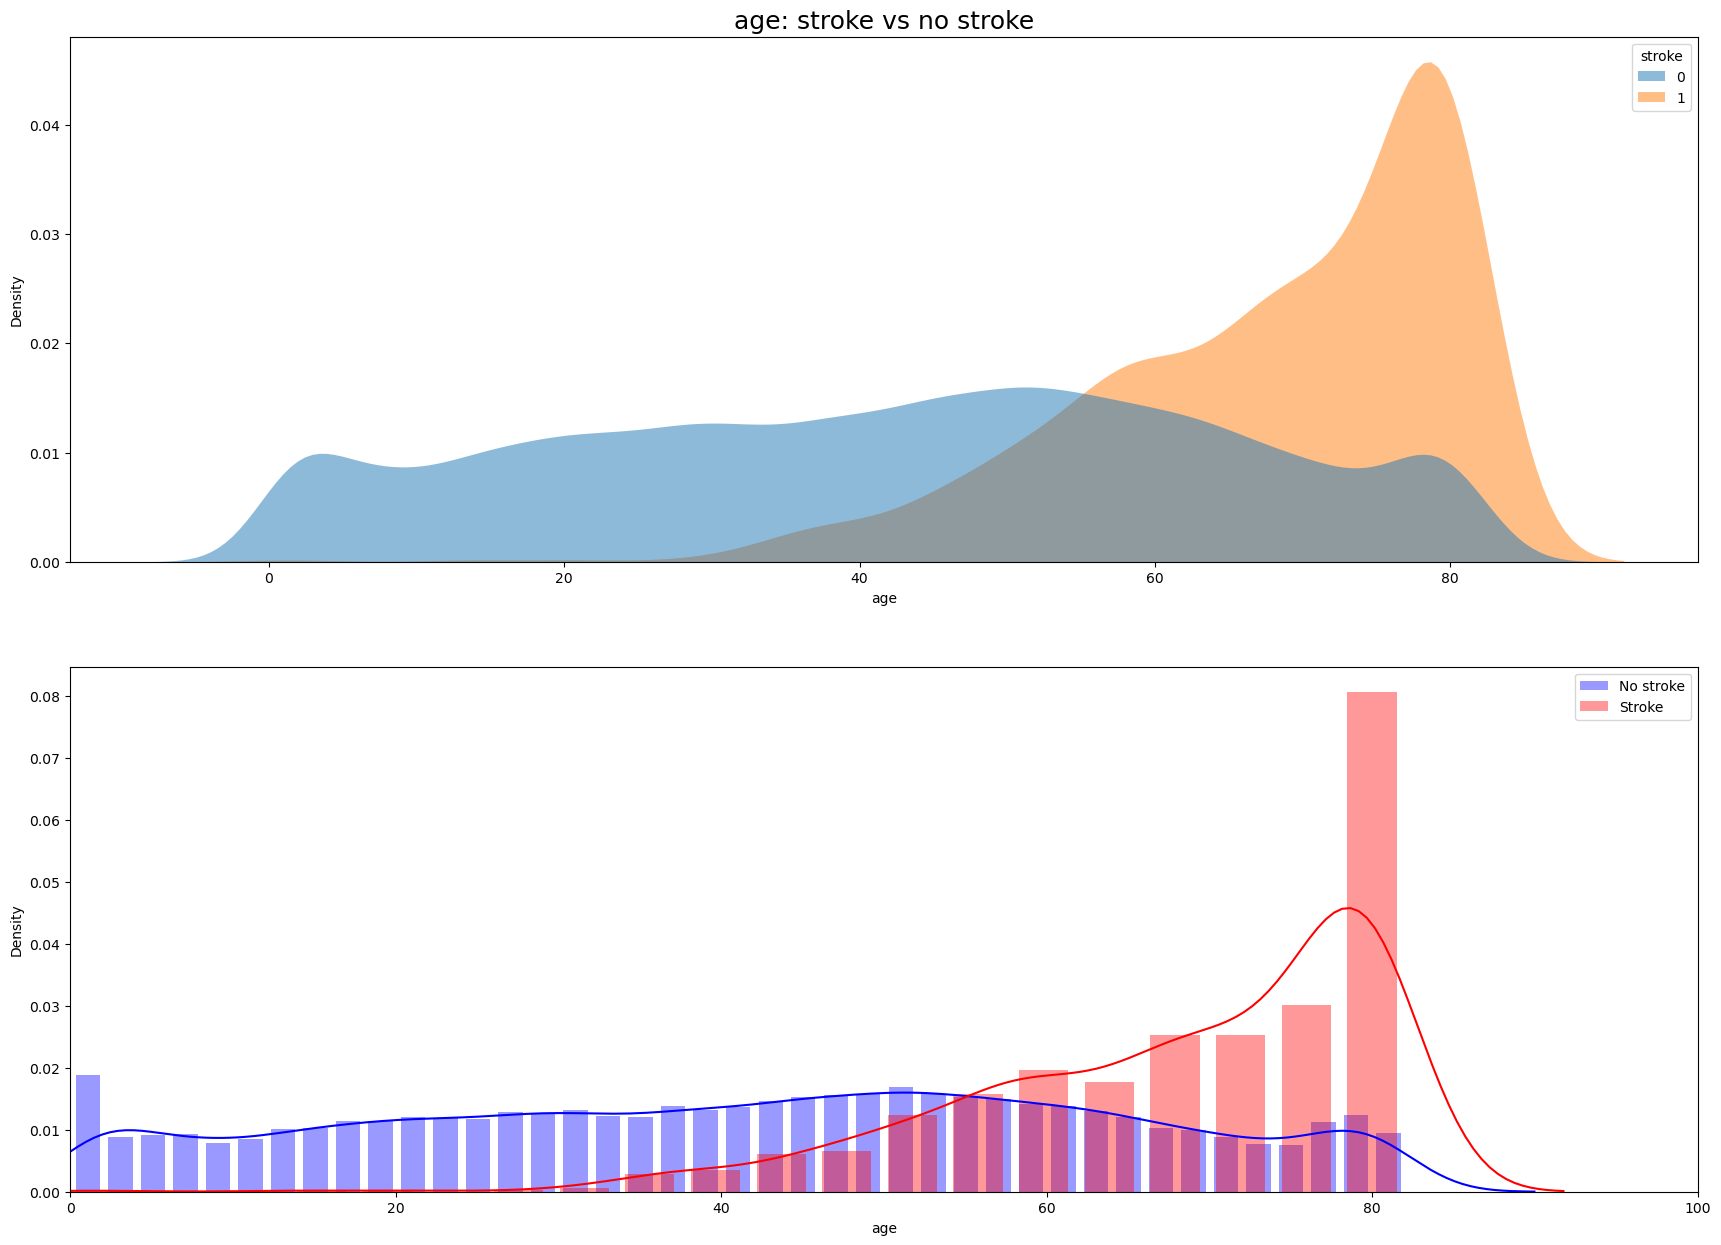

In [23]:
fig, axs = plt.subplots(2,1,figsize=(21,15)) # 2 rows and 1 column

# kernel density estimate (KDE) plot
sns.kdeplot(data=df, x='age', hue="stroke", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0]);
axs[0].set_title('age: stroke vs no stroke', size=18)

# distribution plot (this function combines the matplotlib hist function with the seaborn kdeplot())
sns.distplot(df[df['stroke'] == 0]["age"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75}, ax=axs[1])
sns.distplot(df[df['stroke'] == 1]["age"], label='Stroke', color='red', hist_kws={"rwidth":0.75}, ax=axs[1])

plt.xlim([0,100])
plt.legend()
plt.show()

### **Average glucose level and stroke**

> Risultato: più alto è il livello di glucosio e più si è predisposti ad un ictus

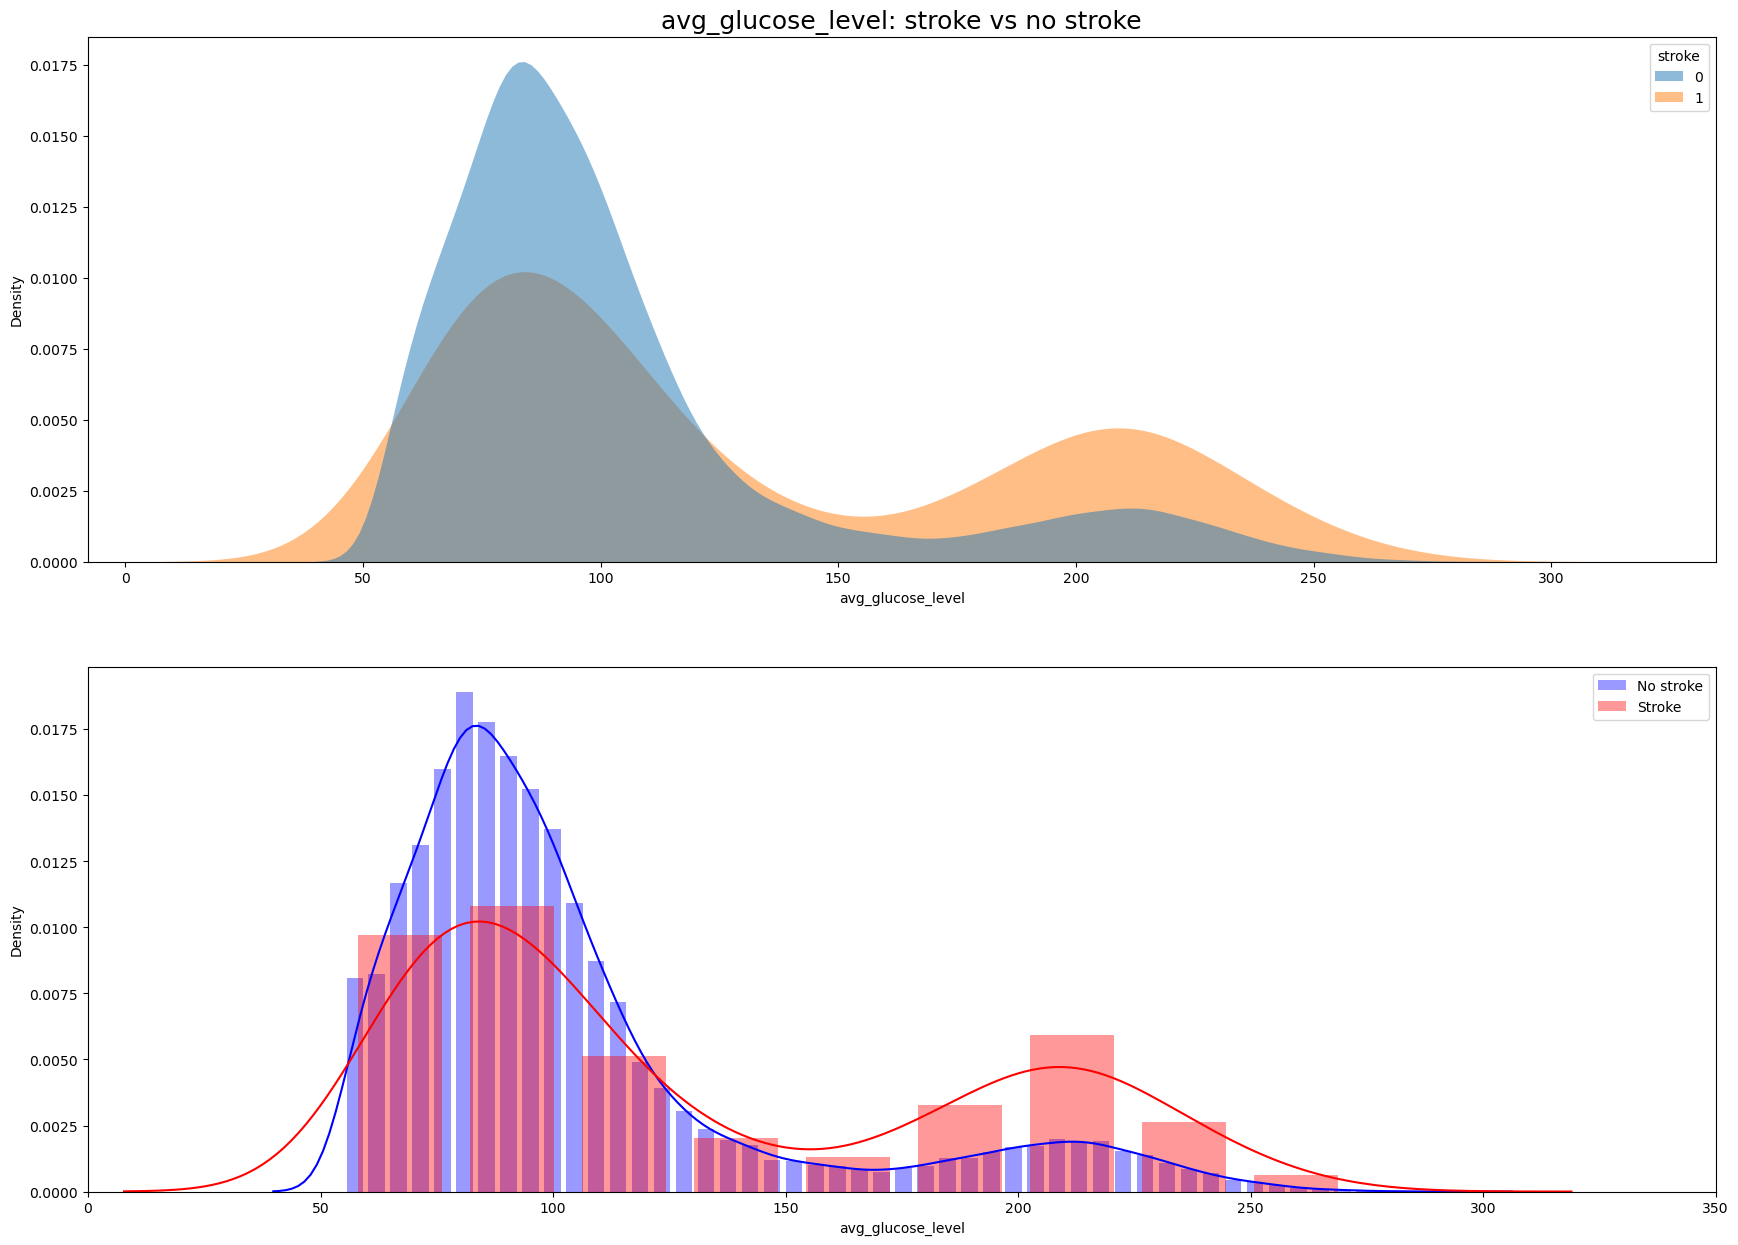

In [24]:
fig, axs = plt.subplots(2,1,figsize=(21,15)) # 2 rows and 1 column

# kernel density estimate (KDE) plot
sns.kdeplot(data=df, x='avg_glucose_level', hue="stroke", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0]);
axs[0].set_title('avg_glucose_level: stroke vs no stroke', size=18)

# distribution plot (this function combines the matplotlib hist function with the seaborn kdeplot())
sns.distplot(df[df['stroke'] == 0]["avg_glucose_level"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75}, ax=axs[1])
sns.distplot(df[df['stroke'] == 1]["avg_glucose_level"], label='Stroke', color='red', hist_kws={"rwidth":0.75}, ax=axs[1])

plt.xlim([0,350])
plt.legend()
plt.show()

### **BMI and strokes**

Le classi di peso per gli adulti indicate dal BMI sono:
* minori di 18.5 = sottopeso;
* 18.5 – 24.9 = normopeso;
* 25 – 29.9 = sovrappeso; 
* maggiori di 30 = obesità.

> Risultato: il bmi ci indica che chi è in sovrappeso rischia di più di avere un ictus, vediamo scendere la probabilità verso l'obesità probabilmente a causa della mancanza di dati.



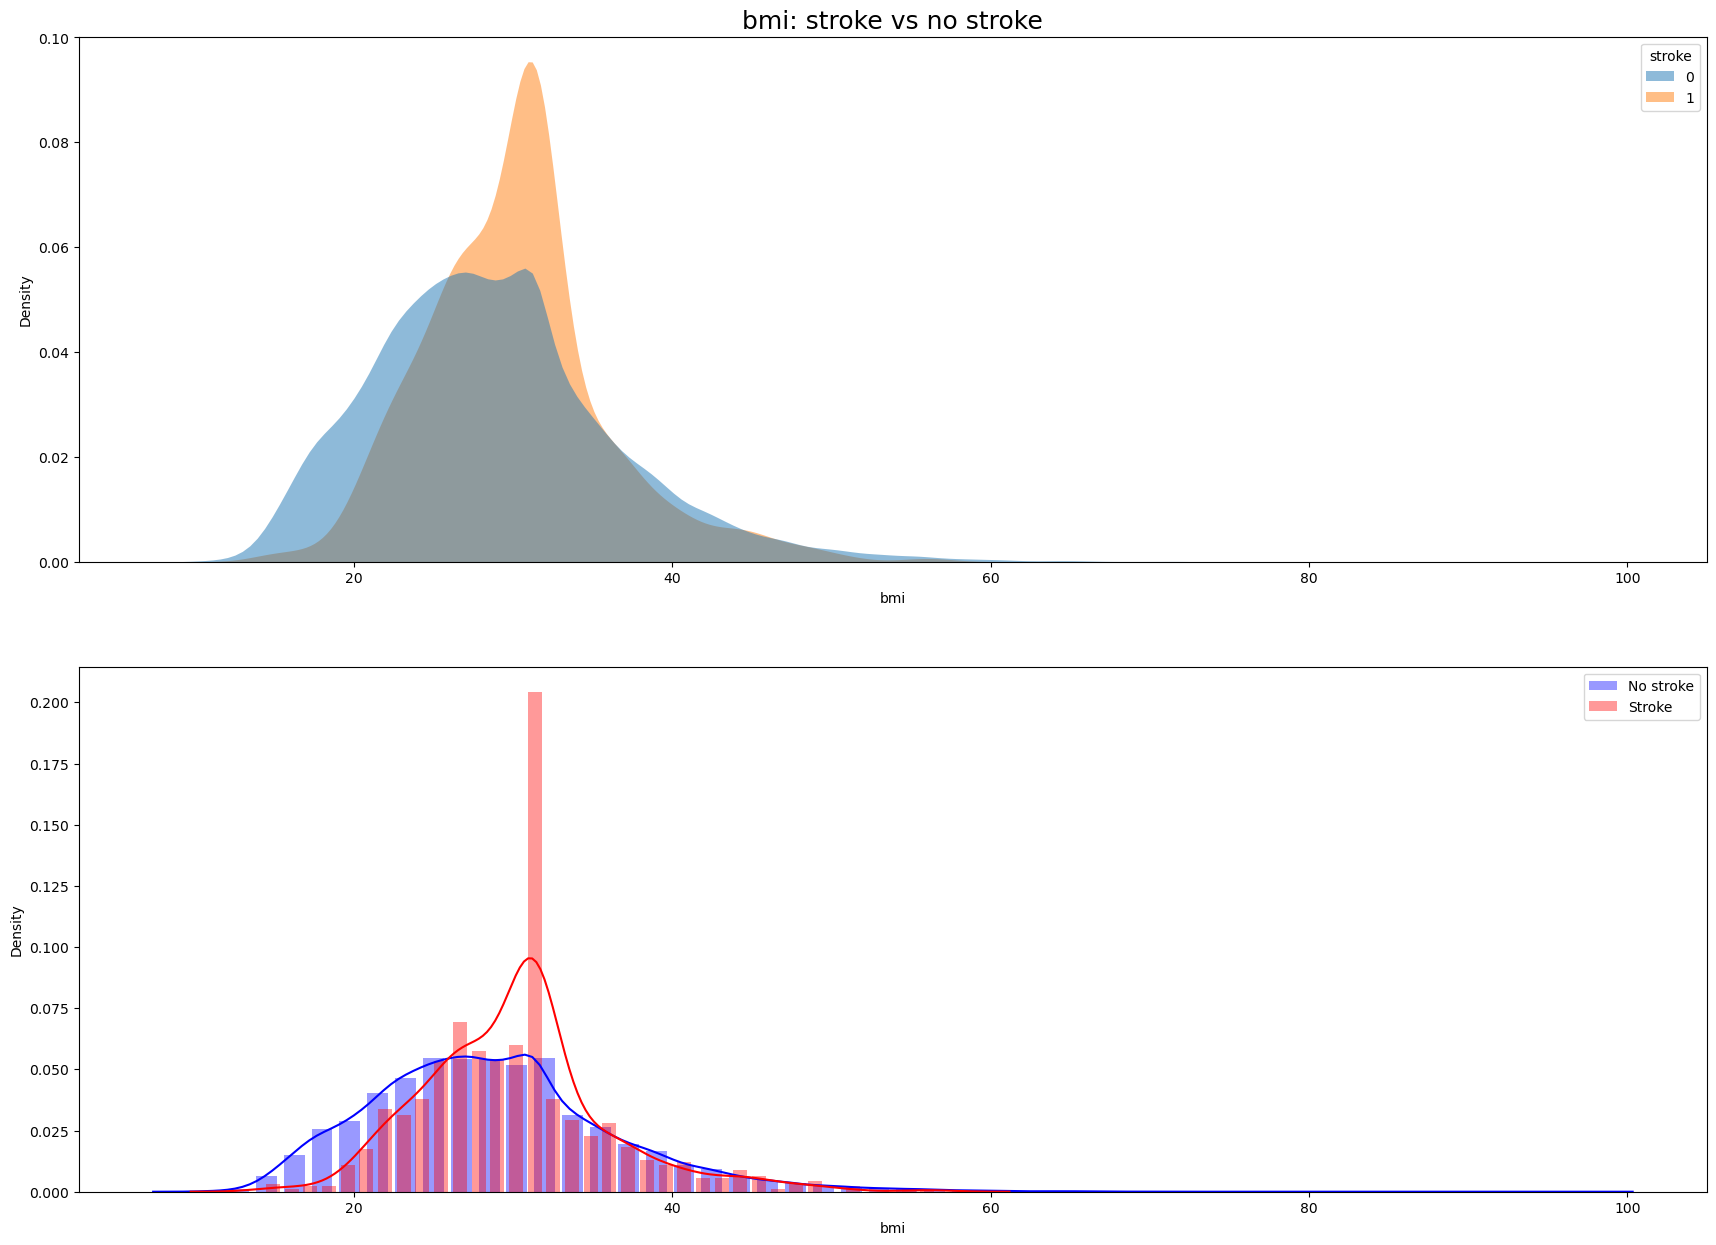

In [25]:
fig, axs = plt.subplots(2,1,figsize=(21,15))  # 2 rows and 1 column

# kernel density estimate (KDE) plot
sns.kdeplot(data=df, x='bmi', hue="stroke", fill=True, common_norm=False, alpha=.5, linewidth=0, ax=axs[0]);
axs[0].set_title('bmi: stroke vs no stroke', size=18)

# distribution plot (this function combines the matplotlib hist function with the seaborn kdeplot())
sns.distplot(df[df['stroke'] == 0]["bmi"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75}, ax=axs[1])
sns.distplot(df[df['stroke'] == 1]["bmi"], label='Stroke', color='red', hist_kws={"rwidth":0.75}, ax=axs[1])

plt.legend()
plt.show()

Notiamo che dal valore 30 (inizio dell'obesità) in poi abbiamo 1900 persone senza ictus e solo 134 che hanno avuto un ictus.

In [26]:
df[df['bmi']>30].groupby('stroke')['stroke'].count()

stroke
0    16464
1      415
Name: stroke, dtype: int64

Ingrandiamo su quel range di valori ovvero i valori >30 e notiamo che la maggior parte delle persone che hanno avuto un ictus sono raggruppate nel range [30 : 33] e poi probabilmente non avendo abbastanza dati la curva inizia a scendere.

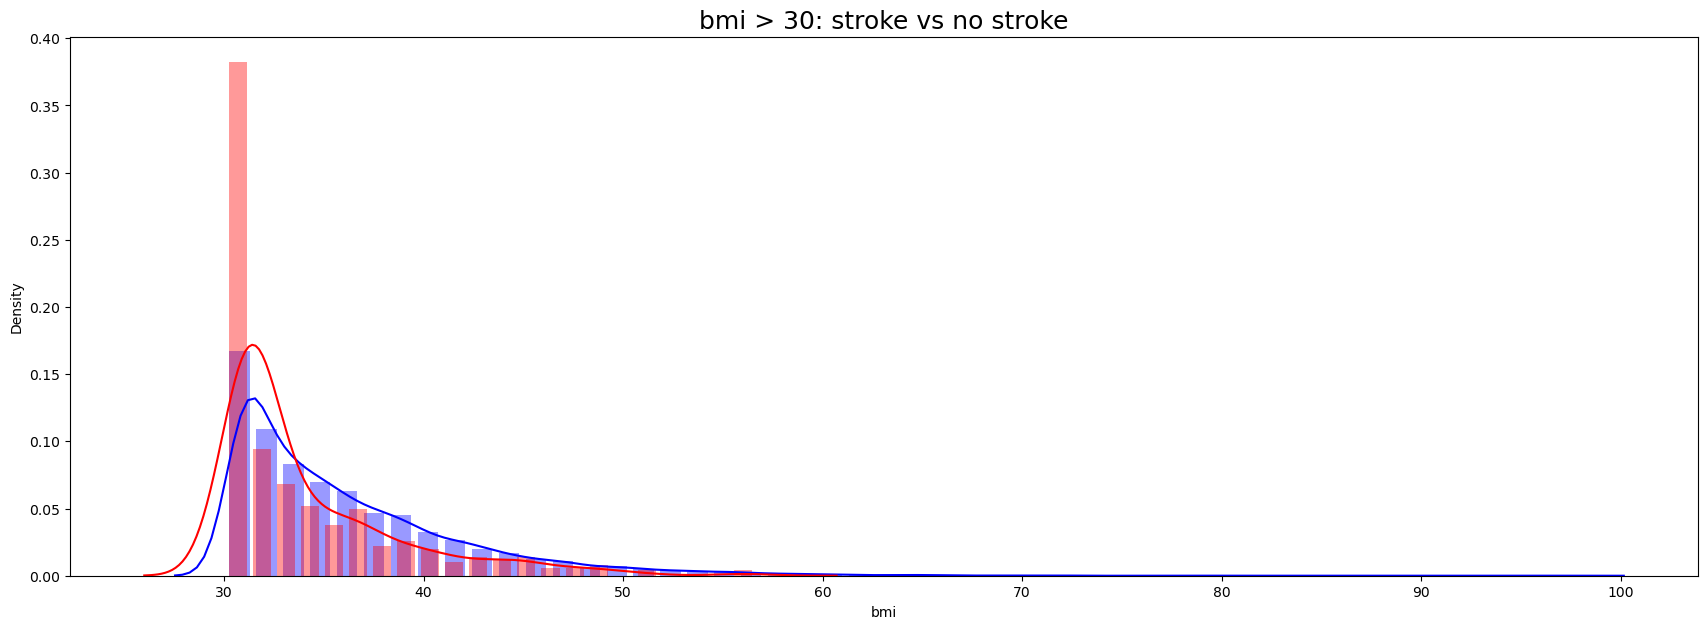

In [27]:
plt.figure(figsize=(21,7))
plt.ylabel('Density', fontsize=10)
plt.title('bmi > 30: stroke vs no stroke', size=18)
sns.distplot(df[(df['stroke'] == 0) & (df['bmi']>30)]["bmi"], label='No stroke',  color='blue', hist_kws={"rwidth":0.75})
sns.distplot(df[(df['stroke'] == 1)& (df['bmi']>30)]["bmi"], label='Stroke', color='red', hist_kws={"rwidth":0.75})
plt.show()

## **Feature Engineering**



*  **Applying Scaler method**





In [28]:
_df = df.copy()
scaler = StandardScaler().fit(_df[numerical])
_df[numerical] = scaler.transform(_df[numerical])

_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,-1.741514,0,0,No,children,Rural,-0.217252,-1.391414,Unknown,0
1,30468,Male,0.700706,1,0,Yes,Private,Urban,-0.383321,1.376245,never smoked,0
2,16523,Female,-1.519494,0,0,No,Private,Urban,0.148517,-1.443634,Unknown,0
3,56543,Female,1.233555,0,0,Yes,Private,Rural,-0.822151,0.945430,formerly smoked,0
4,46136,Male,-1.253070,0,0,No,Never_worked,Rural,1.317261,-1.247809,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43395,56196,Female,-1.430686,0,0,No,children,Urban,-1.063368,-1.078095,never smoked,0
43396,5450,Female,0.611898,0,0,Yes,Govt_job,Urban,2.531001,3.491155,formerly smoked,0
43397,28375,Female,1.766403,1,0,Yes,Private,Urban,-0.291009,0.031580,formerly smoked,0
43398,27973,Male,-0.098566,0,0,Yes,Private,Urban,-0.123549,0.592945,never smoked,0


* **Applying One-hot encoding method**

In [29]:
_df = _df.drop(columns=["id"])

_df = pd.get_dummies(data = _df, columns = np.setdiff1d(_df.columns.values,["age", "bmi", "avg_glucose_level", "heart_disease","hypertension","stroke"]))
_df = _df.reindex(sorted(_df.columns, key=lambda x: x.lower()), axis=1) # sort in alphabetic order

_df

,age,avg_glucose_level,bmi,ever_married_No,ever_married_Yes,gender_Female,gender_Male,heart_disease,hypertension,Residence_type_Rural,...,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown,stroke,work_type_children,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed
0,-1.741514,-0.217252,-1.391414,1,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,0,0
1,0.700706,-0.383321,1.376245,0,1,0,1,0,1,0,...,0,1,0,0,0,0,0,0,1,0
2,-1.519494,0.148517,-1.443634,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,1.233555,-0.822151,0.945430,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,-1.253070,1.317261,-1.247809,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43395,-1.430686,-1.063368,-1.078095,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
43396,0.611898,2.531001,3.491155,0,1,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
43397,1.766403,-0.291009,0.031580,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
43398,-0.098566,-0.123549,0.592945,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## **Features correlation**

> Risultato: nessuna feature influisce in modo particolare sull'avere un ictus. La correlazione più alta trovata è quella della feature 'age' con un valore di 0.2, che rimane comunque un valore molto basso.

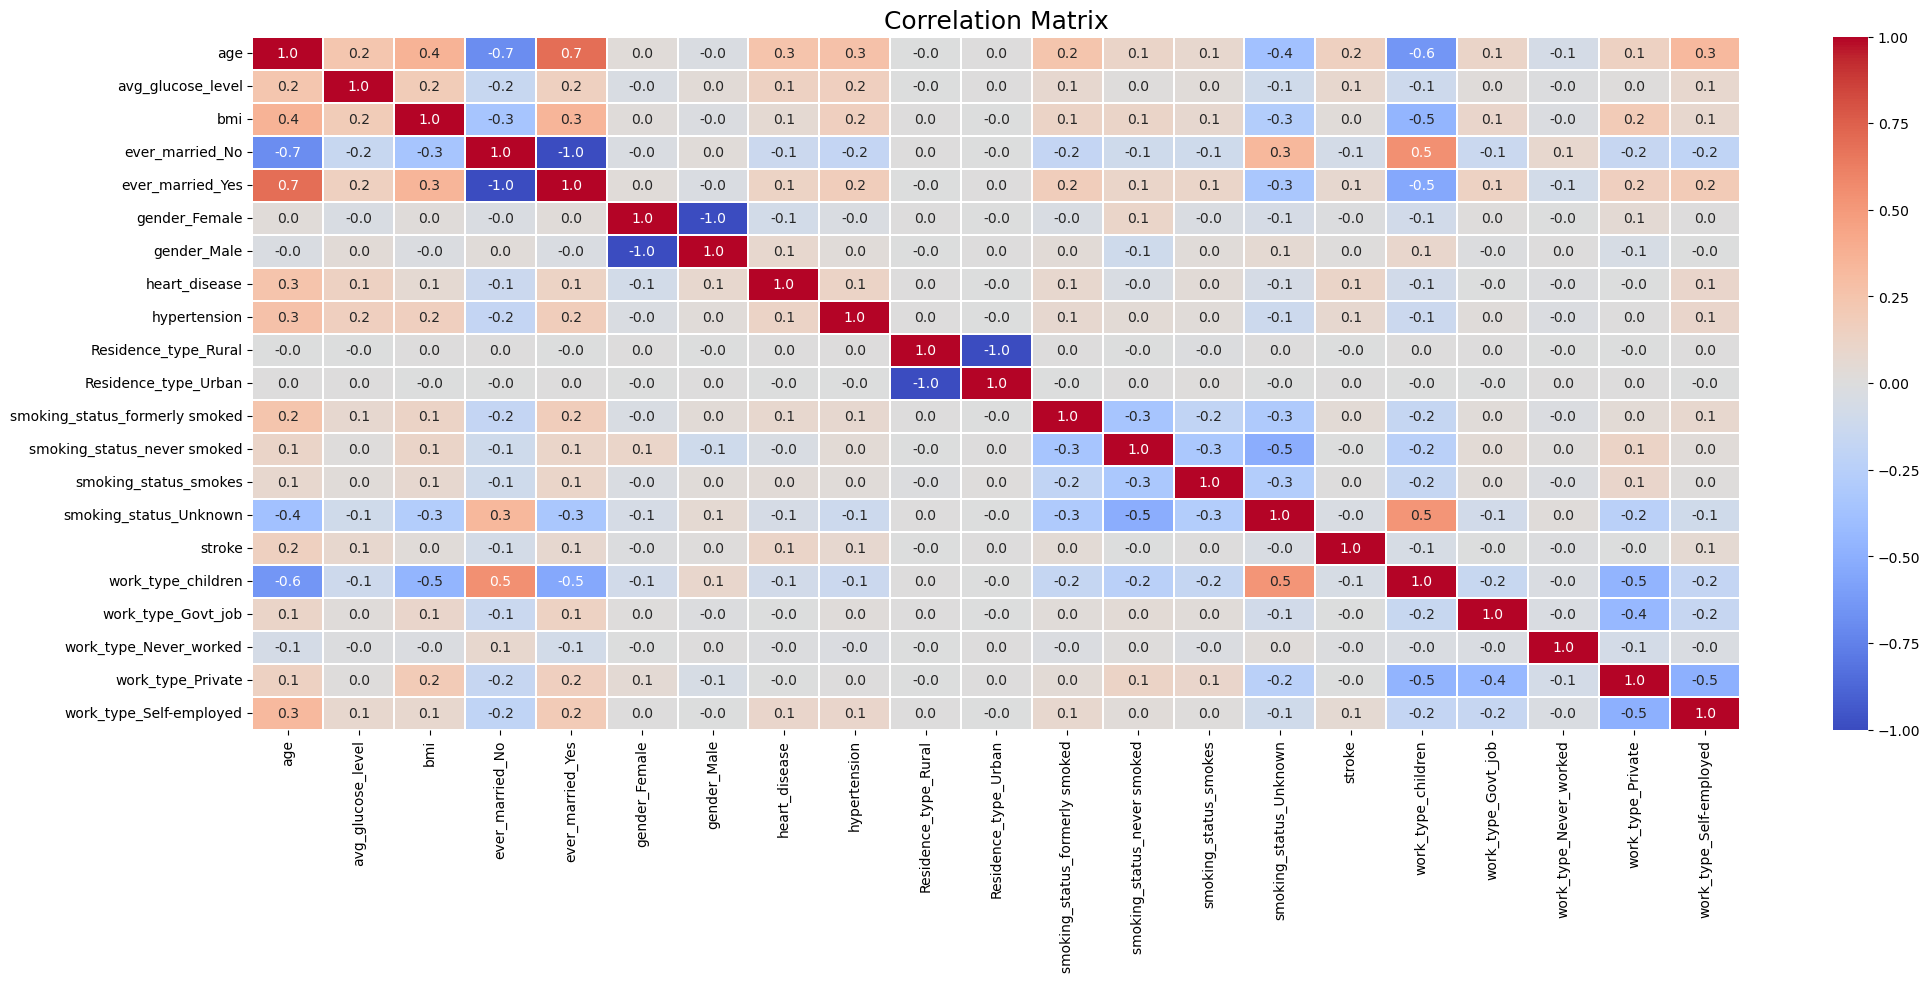

In [30]:
plt.figure(figsize = (24, 9))
sns.heatmap(_df.corr(), cmap = "coolwarm", annot=True, fmt='.1f', linewidths=0.1);
plt.title('Correlation Matrix', size=18)
plt.show()

## **Handle imbalanced data**

Abbiamo visto che i dati non erano bilanciati quindi abbiamo provato ad effettuare un oversampling per vedere se riusciamo ad ottenere un risultato migliore.

In [31]:
_df['stroke'].value_counts()

0    42606
1      783
Name: stroke, dtype: int64

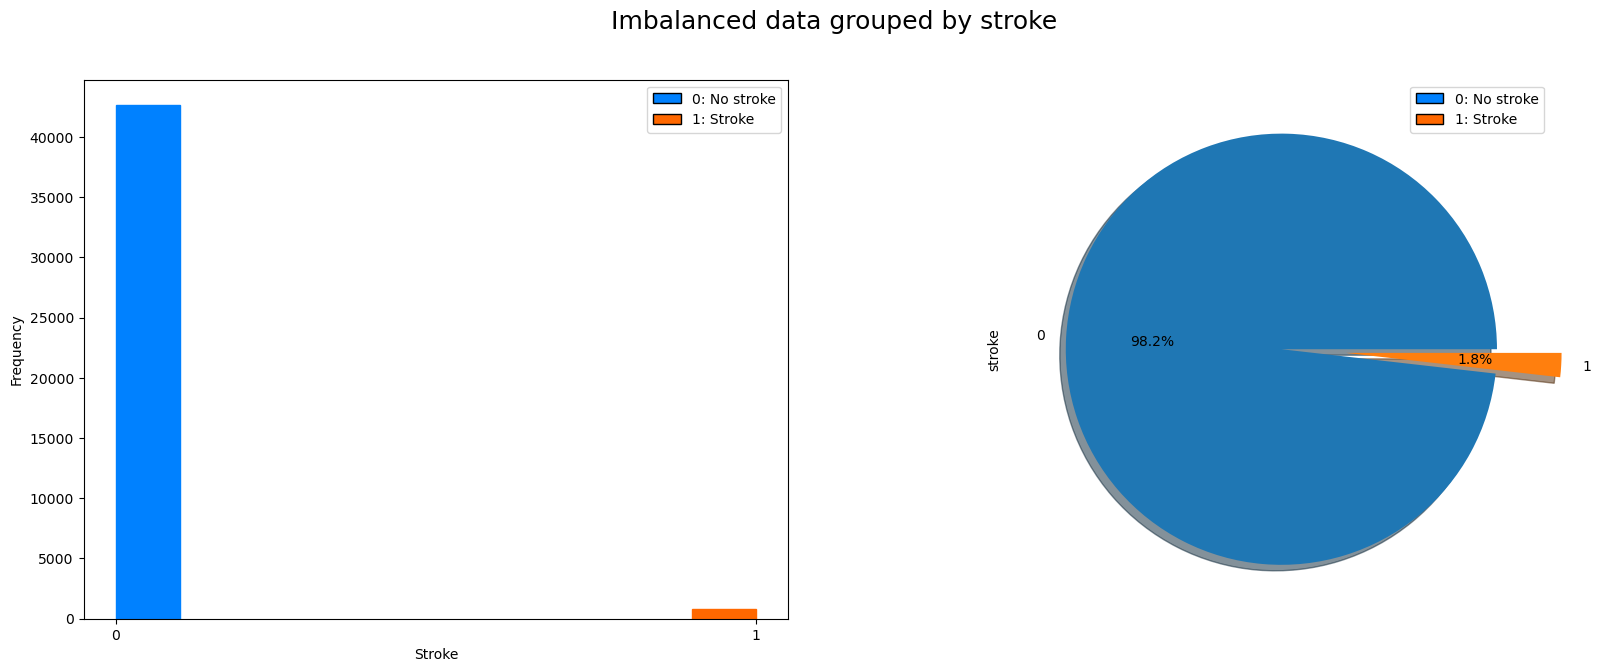

In [32]:
plt.figure(figsize=(20,7))
plt.suptitle('Imbalanced data grouped by stroke', size=18)

# stroke frequency with hist plot
plt.subplot(1, 2, 1)
plt.xlabel('Stroke')
plt.xticks([0,1])
plot = _df['stroke'].plot.hist()
labels= ["0: No stroke","1: Stroke"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[len(plot.patches)-1].set_color(orange)

# stroke distribution with pie chart
plt.subplot(1, 2, 2)
_df.groupby('stroke')['stroke'].count().plot(kind='pie', y='stroke', autopct='%1.1f%%', shadow = True,  explode=(0, 0.3))
plt.legend(handles, labels)
plt.show()

## **Applying SMOTE OverSampling Method**



In [33]:
X = _df.drop('stroke', axis='columns')
y = _df['stroke']

# applying smote method
smote = SMOTE(random_state=42, sampling_strategy=1)
X_over,y_over = smote.fit_resample(X, y)

# rebuild dataframe
df_X_over = pd.DataFrame(X_over, columns=_df.drop('stroke', axis='columns').columns)
df_y_over = pd.DataFrame(y_over, columns=['stroke'])
df_over = pd.concat([df_X_over, df_y_over], axis=1)

df_over['stroke'].value_counts()

0    42606
1    42606
Name: stroke, dtype: int64

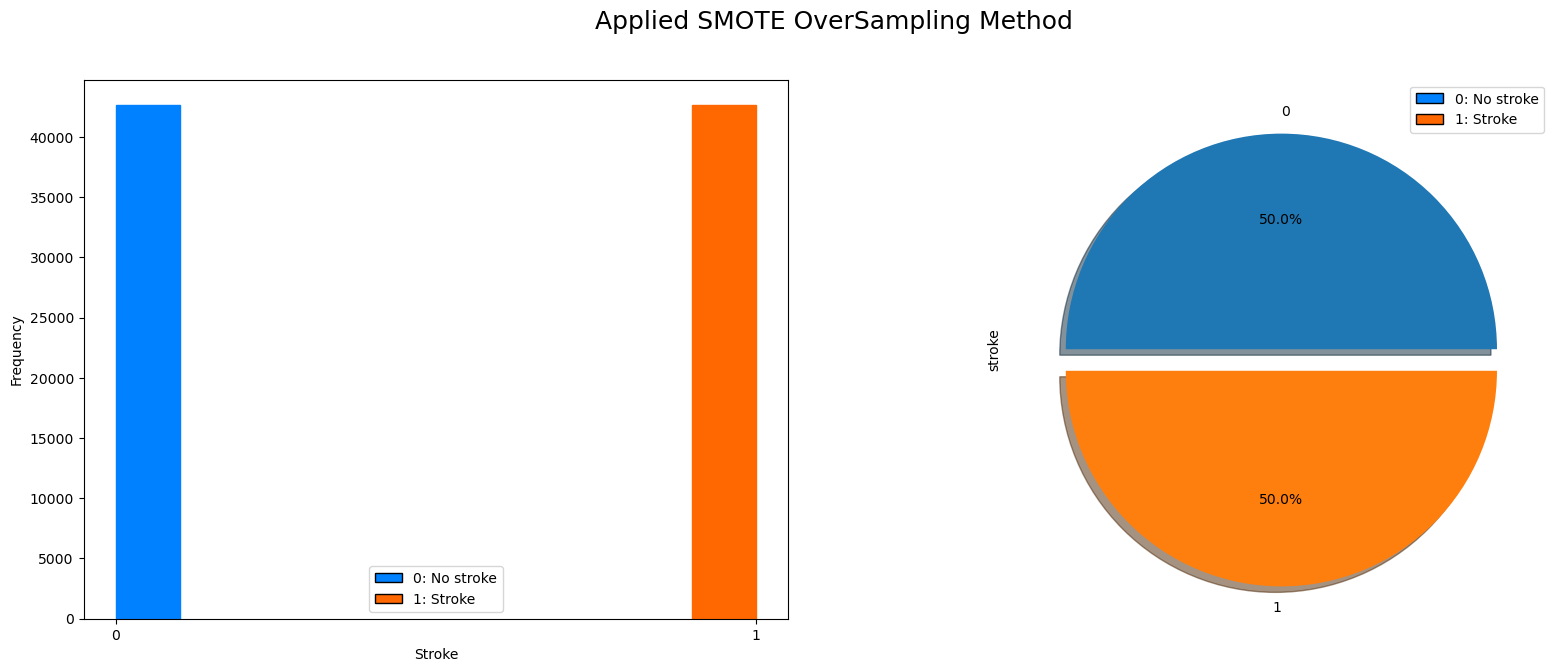

In [34]:
plt.figure(figsize=(20,7))
plt.suptitle('Applied SMOTE OverSampling Method', size=18)

# stroke frequency with hist plot
plt.subplot(1, 2, 1)
plt.xlabel('Stroke')
plt.xticks([0,1])
plot = df_over['stroke'].plot.hist()
labels= ["0: No stroke","1: Stroke"]
plt.legend(handles, labels)
plot.patches[0].set_color(blue)
plot.patches[len(plot.patches)-1].set_color(orange)

# stroke distribution with pie chart
plt.subplot(1, 2, 2)
df_over.groupby('stroke')['stroke'].count().plot(kind='pie', y='stroke', autopct='%1.1f%%', shadow = True, explode=(0, 0.1))
plt.legend(handles, labels)
plt.show()

## **Train-Test Split Phase**

In [35]:
# split the full data 80:20 into training and testing sets respectively
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=2020, shuffle=True)

print('Train set size:', len(X_train),'\nTest set size:', len(X_test))

Train set size: 68169 
Test set size: 17043


In [36]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
print("Accuracy", rfc.score(X_test, y_test)*100, "%")
y_pred_dt = rfc.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_dt))

Accuracy 96.8022061843572 %
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      8603
           1       0.95      0.99      0.97      8440

    accuracy                           0.97     17043
   macro avg       0.97      0.97      0.97     17043
weighted avg       0.97      0.97      0.97     17043



In [37]:
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train,y_train)
# print("LogisticRegression Accuracy", lr.score(X_test, y_test)*100, "%")

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)
print("LogisticRegression Accuracy", lr.score(X_test, y_test)*100, "%")
y_pred_dt = lr.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_dt))

LogisticRegression Accuracy 82.2566449568738 %
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      8603
           1       0.80      0.86      0.83      8440

    accuracy                           0.82     17043
   macro avg       0.82      0.82      0.82     17043
weighted avg       0.82      0.82      0.82     17043



In [39]:
dc = DecisionTreeClassifier()
dc.fit(X_train,y_train)
print("DecisionTreeClassifier Accuracy", dc.score(X_test, y_test)*100, "%")
y_pred_dt = dc.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_dt))

DecisionTreeClassifier Accuracy 96.70245848735551 %
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8603
           1       0.96      0.97      0.97      8440

    accuracy                           0.97     17043
   macro avg       0.97      0.97      0.97     17043
weighted avg       0.97      0.97      0.97     17043



In [40]:
sv = SVC()
sv.fit(X_train,y_train)
print("SVC Accuracy", sv.score(X_test, y_test)*100, "%")
y_pred_dt = sv.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_dt))

SVC Accuracy 87.69582819926069 %
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      8603
           1       0.84      0.93      0.88      8440

    accuracy                           0.88     17043
   macro avg       0.88      0.88      0.88     17043
weighted avg       0.88      0.88      0.88     17043



## **Features Importance**

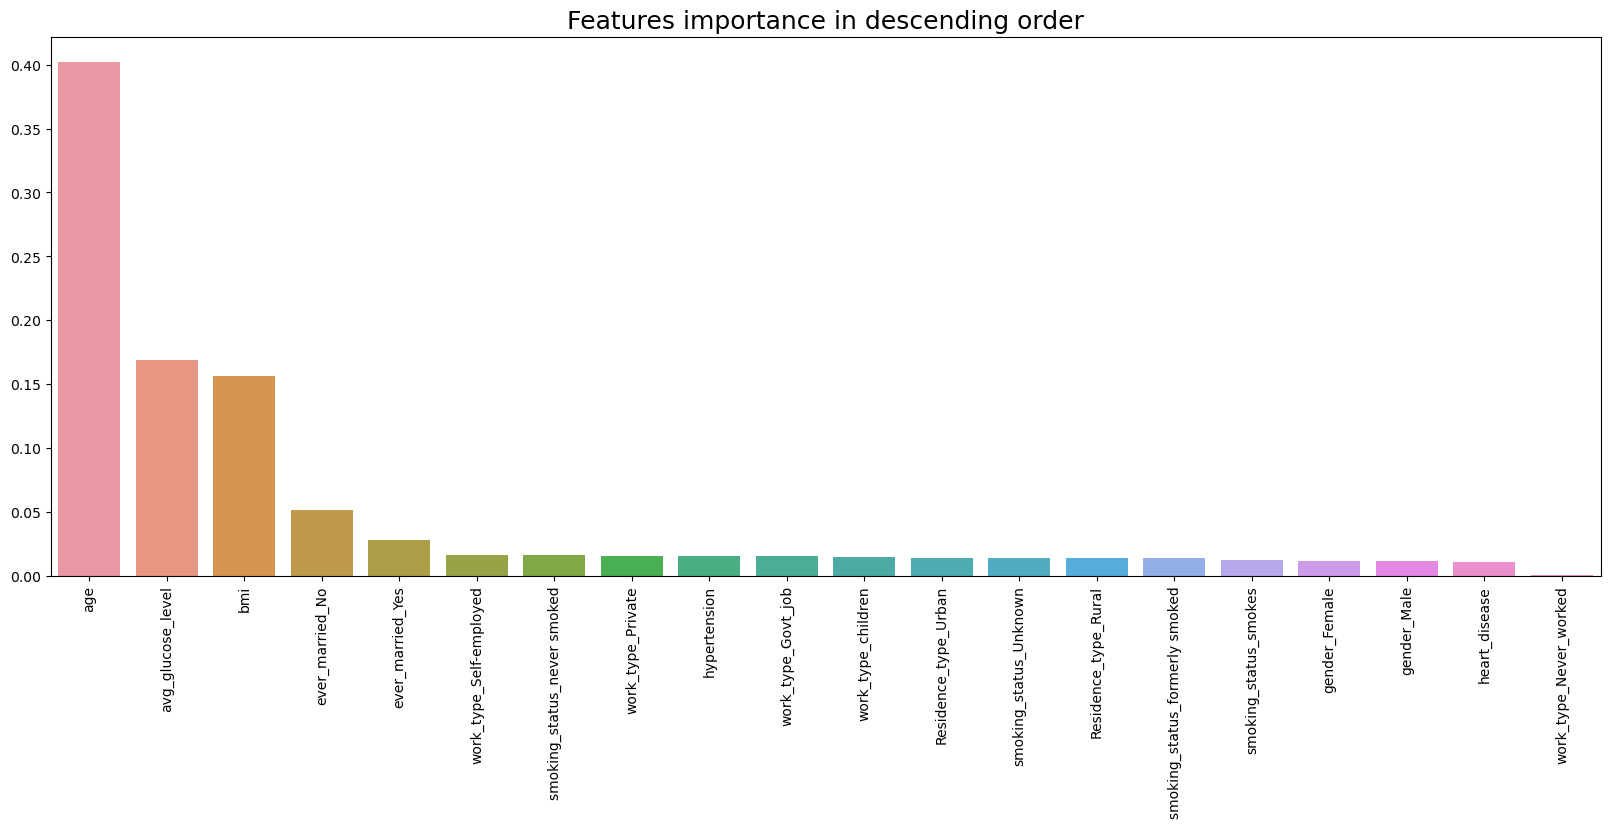

In [41]:
importance = rfc.feature_importances_ # get importance values of the features for the model

features = list(zip(_df.drop('stroke', axis='columns').columns, importance)) # zip column names with their importance value
features.sort(key=lambda tup: tup[1], reverse=True) # order features by value in descending order

plt.figure(figsize=(20,7))
sns.barplot(x=[feature for feature, importance in features], y=[importance for feature, importance in features])
plt.xticks(rotation=90)
plt.title('Features importance in descending order', size=18)
plt.show()

## **Test if predict a stroke in our patient**

In [46]:
data = {
 'age': 97,
 'avg_glucose_level': 350,
 'bmi': 62.5,
 'ever_married_No': 0,
 'ever_married_Yes': 1,
 'gender_Female': 1,
 'gender_Male': 0,
 'heart_disease': 1,
 'hypertension': 0,
 'Residence_type_Rural': 1,
 'Residence_type_Urban': 0,
 'smoking_status_formerly smoked': 0,
 'smoking_status_never smoked': ,
 'smoking_status_smokes': 0,
 'smoking_status_Unknown': 1,
 'work_type_children': 0,
 'work_type_Govt_job': 0,
 'work_type_Never_worked': 0,
 'work_type_Private': 1,
 'work_type_Self-employed': 0}

predict_input = pd.DataFrame(data, index=[0])
predict_input[numerical] = scaler.transform(predict_input[numerical]) # applying standard scaler on numerical fields
predict_input

,age,avg_glucose_level,bmi,ever_married_No,ever_married_Yes,gender_Female,gender_Male,heart_disease,hypertension,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,smoking_status_Unknown,work_type_children,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed
0,6.872863,5.694426,4.41806,0,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0


In [47]:
predict_result = rfc.predict(predict_input)[0]

if predict_result:
    print("Stroke predicted!")
else:
    print("No stroke risk.")

print("Stroke probability:", rfc.predict_proba(predict_input)[0][1], sep=' ')

No stroke risk.
Stroke probability: 0.09
